In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevents column wrapping in Jupyter Notebook
pd.set_option('display.width', 1000)  # Adjusts the display width to fit more columns

In [2]:
from sklearn.metrics import precision_recall_fscore_support

def find_best_contamination_for_isolation_forest(X, y):
    best_f1, best_c = 0, None
    for c in np.arange(0.01, 0.2, 0.01):
        model = IsolationForest(contamination=c, random_state=42)
        anomaly_score = model.fit_predict(X)

        _, _, f1, _ = precision_recall_fscore_support(y, anomaly_score, average='binary')

        if f1 > best_f1:
            best_f1 = f1
            best_c = c
    
    return best_c, best_f1

In [25]:
def visualize_isolation_forest_results(X, features, anomaly_score, min, max):
    data = X.loc[min:max]
    selected_indices = X.index.get_indexer_for(data.index)
    colors = np.where(anomaly_score[selected_indices] == -1, 'red', 'blue')


    for feature in X.columns:
        if X.get(feature) is None:
            continue
        
        plt.figure(figsize=(10, 6))
        print(f"Index: {data.index.shape}")
        print(f"Features: {data[feature].shape}")
        plt.scatter(data.index, data[feature], c=colors, alpha=0.6)

        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="Normal"),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Anomaly")
        ]

        plt.xlabel("Index")
        plt.ylabel(feature)
        plt.title(f"Isolation Forest - {feature}")
        plt.legend(handles=handles, title="Traffic Type")

        # Show the plot
        plt.show()

def score_model(anomaly_score, y):
    print("\nClassification Report:\n", classification_report(y, anomaly_score, labels=[1, -1], target_names=["Normal", "Anomaly"]))

In [18]:
def engineer_rolling_features(df, window='5s'):
    """
    Create rolling (moving) features over a specified time window (default 5 seconds).
    Assumes df has a DateTime index (e.g. df.index = df['datetime']).
    Example features:
      1. Rolling sum of SYN flags
      2. Rolling mean of packet count
      3. Rolling std of bytes_rate
    """
    # Ensure the DataFrame is sorted by its time index
    df = df.sort_index()
    
    # 1) Rolling sum of SYN flags over the last 5s
    if 'syn_flag_counts' in df.columns:
        df['rolling_syn_5s'] = (
            df['syn_flag_counts']
            .rolling(window=window, min_periods=1)
            .sum()
        )
    else:
        df['rolling_syn_5s'] = 0

    # 2) Rolling mean of packets_count over the last 5s
    if 'packets_count' in df.columns:
        df['rolling_packets_mean_5s'] = (
            df['packets_count']
            .rolling(window=window, min_periods=1)
            .mean()
        )
    else:
        df['rolling_packets_mean_5s'] = 0

    # 3) Rolling std of bytes_rate over the last 5s
    if 'bytes_rate' in df.columns:
        df['rolling_bytes_rate_std_5s'] = (
            df['bytes_rate']
            .rolling(window=window, min_periods=1)
            .std()
        )
    else:
        df['rolling_bytes_rate_std_5s'] = 0

    return df

def engineer_extra_features(df):
    """
    Add five additional features that capture important ratios and fractions:
      1. FWD/BWD Payload Ratio
      2. Fraction of Forward Packets
      3. Fraction of SYN Flags
      4. Fraction of RST Flags
      5. Header-to-Payload Ratio
    """
    
    # 2) Fraction of forward packets:
    if 'fwd_packets_count' in df.columns and 'packets_count' in df.columns:
        df['fwd_packet_fraction'] = df['fwd_packets_count'] / (df['packets_count'] + 1)
    else:
        df['fwd_packet_fraction'] = 0
    
    # 3) Fraction of SYN flags:
    if 'syn_flag_counts' in df.columns and 'packets_count' in df.columns:
        df['frac_syn'] = df['syn_flag_counts'] / (df['packets_count'] + 1)
    else:
        df['frac_syn'] = 0
    
    # 4) Fraction of RST flags:
    if 'rst_flag_counts' in df.columns and 'packets_count' in df.columns:
        df['frac_rst'] = df['rst_flag_counts'] / (df['packets_count'] + 1)
    else:
        df['frac_rst'] = 0
    
    # 5) Header-to-Payload ratio:
    if 'total_header_bytes' in df.columns and 'total_payload_bytes' in df.columns:
        df['header_to_payload_ratio'] = df['total_header_bytes'] / (df['total_payload_bytes'] + 1)
    else:
        df['header_to_payload_ratio'] = 0
    
    return df

def process_raw_data(dataset):
    dataset['calculated_bwd_avg_segment_size'] = dataset['bwd_total_payload_bytes'] / (dataset['bwd_packets_count'] + 1)

def post_process_aggregations(dataset):
    dataset['requests_rate_src_port'] = dataset['requests_rate'] * dataset['src_ip']
    dataset['requests_rate_dst_port'] = dataset['requests_rate'] * dataset['dst_ip']

    return ['requests_rate_src_port', 'requests_rate_dst_port']

def engineer_portscan_features(df):
    """
    Given an aggregated DataFrame, create new features that help 
    identify port scanning behavior. Common columns used include:
      - syn_flag_counts, rst_flag_counts, ack_flag_counts
      - dst_port (unique count of dest ports in a window)
      - src_port (unique count of src ports in a window)
      - packets_count, fwd_packets_count, bwd_packets_count
      - requests_rate
    """
    
 
    if 'dst_port' in df.columns and 'requests_rate' in df.columns:
        df['unique_dst_port_ratio'] = df['dst_port'] / (df['requests_rate'] + 1)
    if 'src_port' in df.columns and 'requests_rate' in df.columns:
        df['unique_src_port_ratio'] = df['src_port'] / (df['requests_rate'] + 1)

    return df


def load_data(file_path, label):
    df = pd.read_csv(file_path)
    df['label'] = label
    df['requests_rate'] = 1
    return df

# def load_prepared_dataset(filename, label, aggregations)

def load_and_prepare_sets(benign_file_name, malign_file_name, aggregations, include_labels=False, frequency='1s'):
    benign_data = load_data(f'./BCCC-CIC-IDS-2017/{benign_file_name}', 'benign')
    ddos_data = load_data(f'./BCCC-CIC-IDS-2017/{malign_file_name}', 'ddos')

    benign_data['datetime'] = pd.to_datetime(benign_data['timestamp'], format='mixed')
    benign_data.set_index('datetime', inplace=True)
    benign_data.sort_index(inplace=True)

    ddos_data['datetime'] = pd.to_datetime(ddos_data['timestamp'])
    ddos_data.set_index('datetime', inplace=True)
    ddos_data.sort_index(inplace=True)

    bening_subnet = benign_data[(benign_data['dst_ip'].str.startswith('192.168'))]
    ddos_subnet = ddos_data[ddos_data['dst_ip'].str.startswith('192.168')]

    bening_subnet = pd.get_dummies(bening_subnet, columns=['protocol'], drop_first=True, dtype=int)
    ddos_subnet = pd.get_dummies(ddos_subnet, columns=['protocol'], drop_first=True, dtype=int)

    protocol_cols = [col for col in np.unique(np.concat([bening_subnet.columns, ddos_subnet.columns])) if col.startswith('protocol_')]
    aggregations.update({col: 'count' for col in protocol_cols})

    for col in protocol_cols:
        if col not in bening_subnet.columns:
            bening_subnet[col] = 0
        if col not in ddos_subnet.columns:
            ddos_subnet[col] = 0
    
    process_raw_data(bening_subnet)
    process_raw_data(ddos_subnet)
   
    if include_labels:
        aggregations['label'] = lambda x: 1 if x.eq('benign').all() else -1
        
    bening_subnet_agg = bening_subnet.resample(frequency).agg(aggregations)

    ddos_subnet_agg = ddos_subnet.resample(frequency).agg(aggregations)

    if include_labels:
        aggregations.pop('label', None)

    combined_data = pd.concat([ddos_subnet, bening_subnet])
    combined_data['datetime'] = pd.to_datetime(combined_data['timestamp'], format='mixed')
    combined_data.set_index('datetime', inplace=True)
    combined_data.sort_index(inplace=True)

    aggregations['label'] = lambda x: 1 if x.eq('benign').all() else -1
    combined_data_agg = combined_data.resample(frequency).agg(aggregations)
    aggregations.pop('label', None)

    post_process_aggregations(combined_data_agg)
    post_process_aggregations(bening_subnet_agg)
    post_process_aggregations(ddos_subnet_agg)

    combined_data_agg = engineer_portscan_features(combined_data_agg)
    bening_subnet_agg = engineer_portscan_features(bening_subnet_agg)
    ddos_subnet_agg   = engineer_portscan_features(ddos_subnet_agg)

    combined_data_agg = combined_data_agg.drop(columns=['src_port', 'dst_port'])
    bening_subnet_agg = bening_subnet_agg.drop(columns=['src_port', 'dst_port'])
    ddos_subnet_agg = ddos_subnet_agg.drop(columns=['src_port', 'dst_port'])

    combined_data_agg = engineer_extra_features(combined_data_agg)
    bening_subnet_agg = engineer_extra_features(bening_subnet_agg)
    ddos_subnet_agg   = engineer_extra_features(ddos_subnet_agg)

    combined_data_agg = engineer_rolling_features(combined_data_agg, window='5s')
    bening_subnet_agg = engineer_rolling_features(bening_subnet_agg, window='5s')
    ddos_subnet_agg   = engineer_rolling_features(ddos_subnet_agg, window='5s')

    features = bening_subnet_agg.keys()

    features = features[features != 'dst_port']
    features = features[features != 'src_port']
    features = features[features != 'dst_ip']
    features = features[features != 'src_ip']

    return bening_subnet, bening_subnet_agg, ddos_subnet, ddos_subnet_agg, combined_data, combined_data_agg, features

In [ ]:
def safe_agg(func, default=0):
    """
    Returns a function that, when applied to a pandas Series, checks if it's empty.
    If not empty, applies `func` to the Series. If empty, returns `default`.
    """
    def wrapper(series):
        if not series.empty:
            return func(series)
        else:
            return default
    return wrapper


aggregations = {
    'syn_flag_counts':          safe_agg(pd.Series.sum),       # sum of SYN flags
    'rst_flag_counts':          safe_agg(pd.Series.sum),       # sum of RST flags
    'ack_flag_counts':          safe_agg(pd.Series.sum),       # sum of ACK flags
    'packets_count':            safe_agg(pd.Series.sum),       # total packets per second
    'fwd_packets_count':        safe_agg(pd.Series.sum),
    'bwd_packets_count':        safe_agg(pd.Series.sum),
    'dst_port':                 safe_agg(pd.Series.nunique),   # distinct dst ports
    'src_port':                 safe_agg(pd.Series.nunique),   # distinct src ports
    'src_ip':                   safe_agg(pd.Series.nunique),   # distinct src IPs
    'dst_ip':                   safe_agg(pd.Series.nunique),   # distinct dst IPs

    'bytes_rate': safe_agg(pd.Series.mean),                # or x.mean() if not empty else 0
    'requests_rate': safe_agg(pd.Series.count),                # count of rows in this group
    'psh_flag_counts': safe_agg(pd.Series.sum),

    'calculated_bwd_avg_segment_size': safe_agg(pd.Series.mean),
    'bwd_payload_bytes_mean':          safe_agg(pd.Series.sum),
    'bwd_init_win_bytes':             safe_agg(pd.Series.mean),
    'subflow_bwd_bytes':              safe_agg(pd.Series.sum),
    'bwd_total_payload_bytes':        safe_agg(pd.Series.sum),
    'fwd_payload_bytes_min':          safe_agg(pd.Series.min),
    'bwd_payload_bytes_max':          safe_agg(pd.Series.max),
    
    'packet_IAT_std':  safe_agg(pd.Series.std),
    'packet_IAT_min':  safe_agg(pd.Series.min),
    'packet_IAT_total': safe_agg(pd.Series.sum),
}
bening, bening_subnet_agg, ddos, ddos_subnet_agg, combined, combined_data_agg, features = load_and_prepare_sets("friday_benign.csv", "portscan.csv", aggregations, frequency='1s')

combined_data_agg.describe()

/var/folders/bm/wq_7x62n7_16_jwz7q1h_v440000gn/T/ipykernel_72916/2721913366.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))


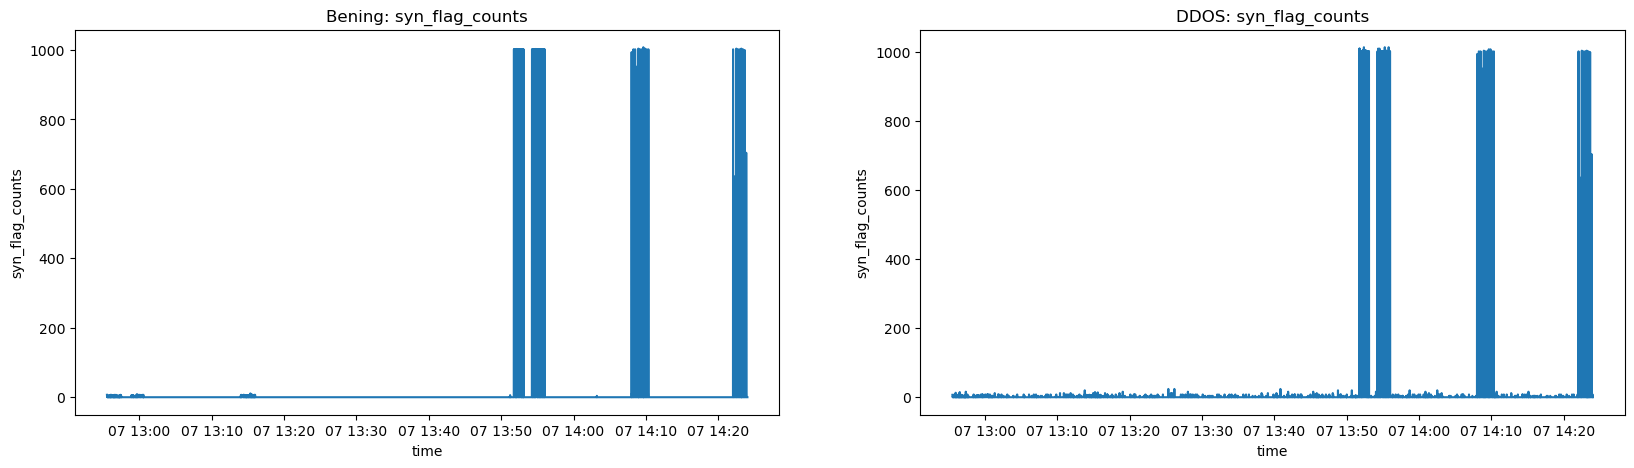

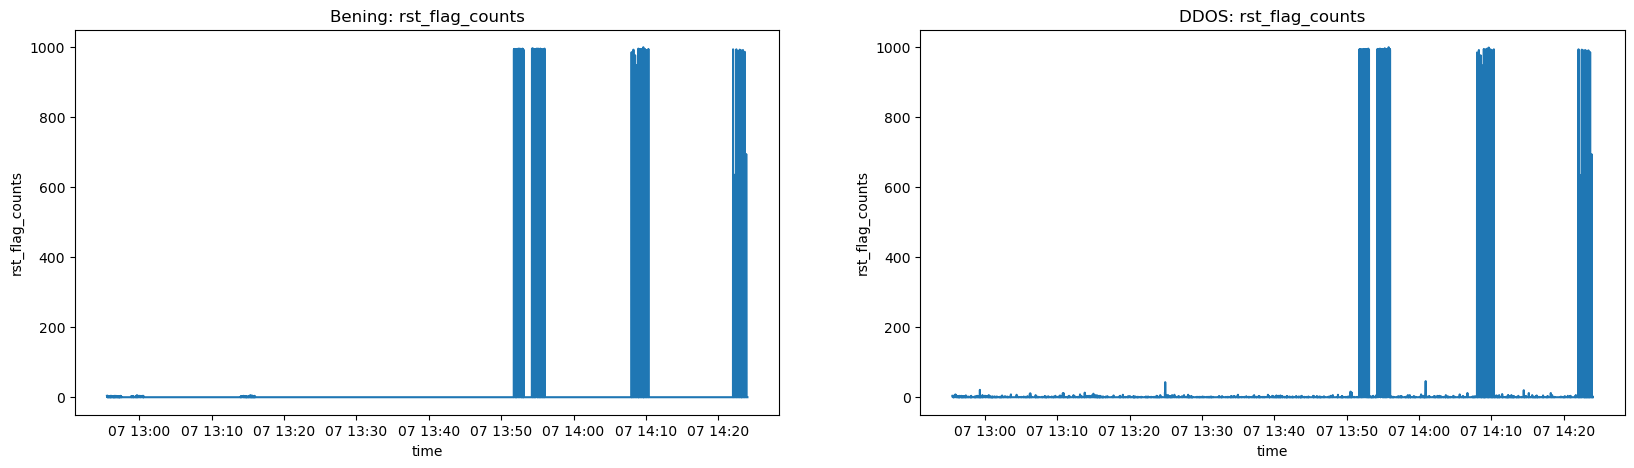

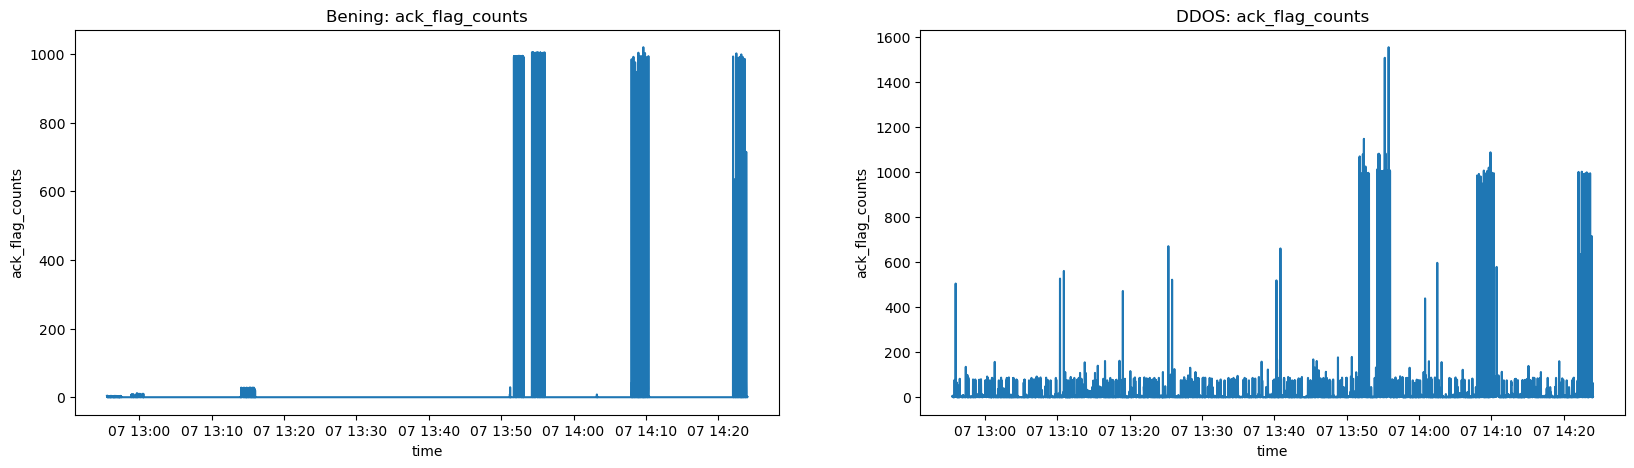

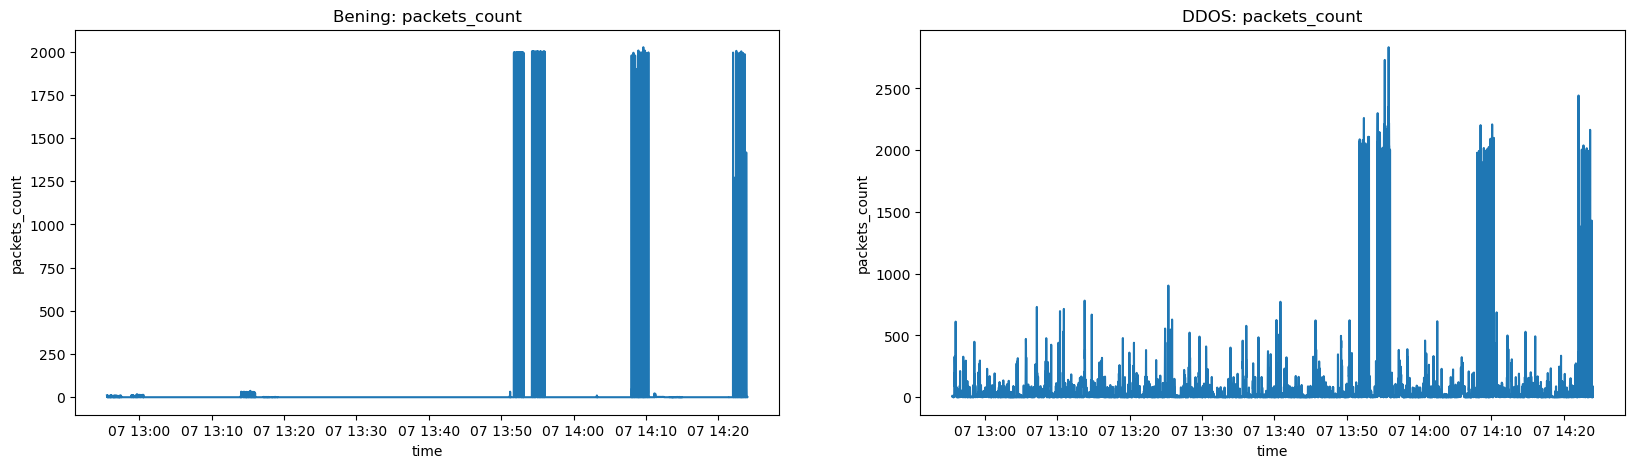

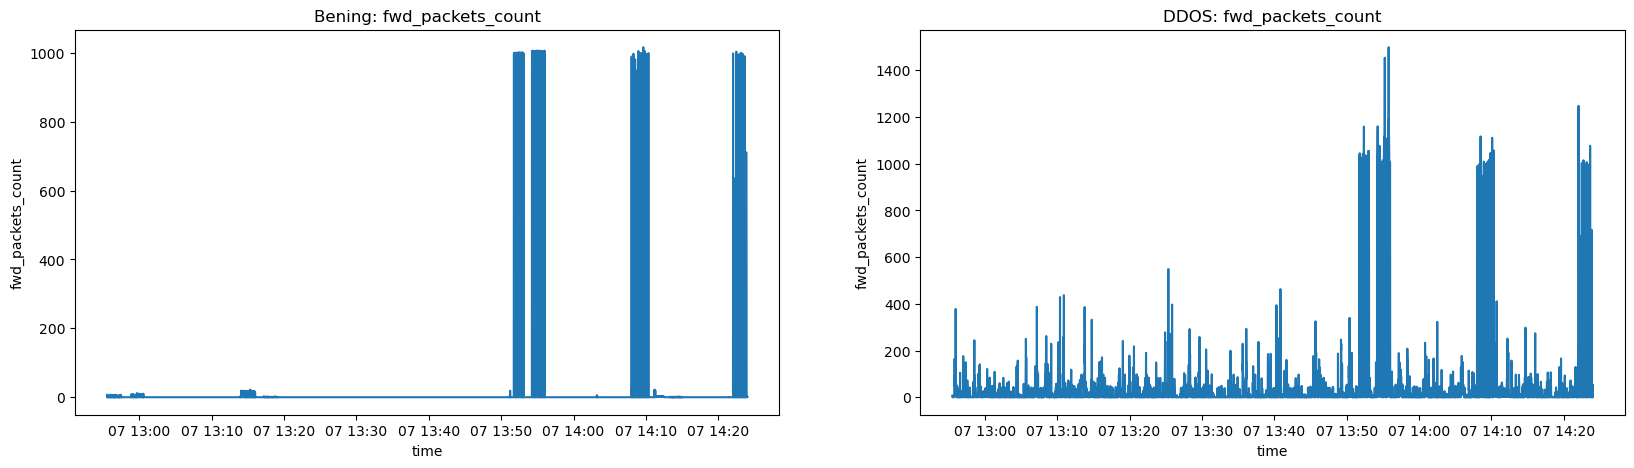

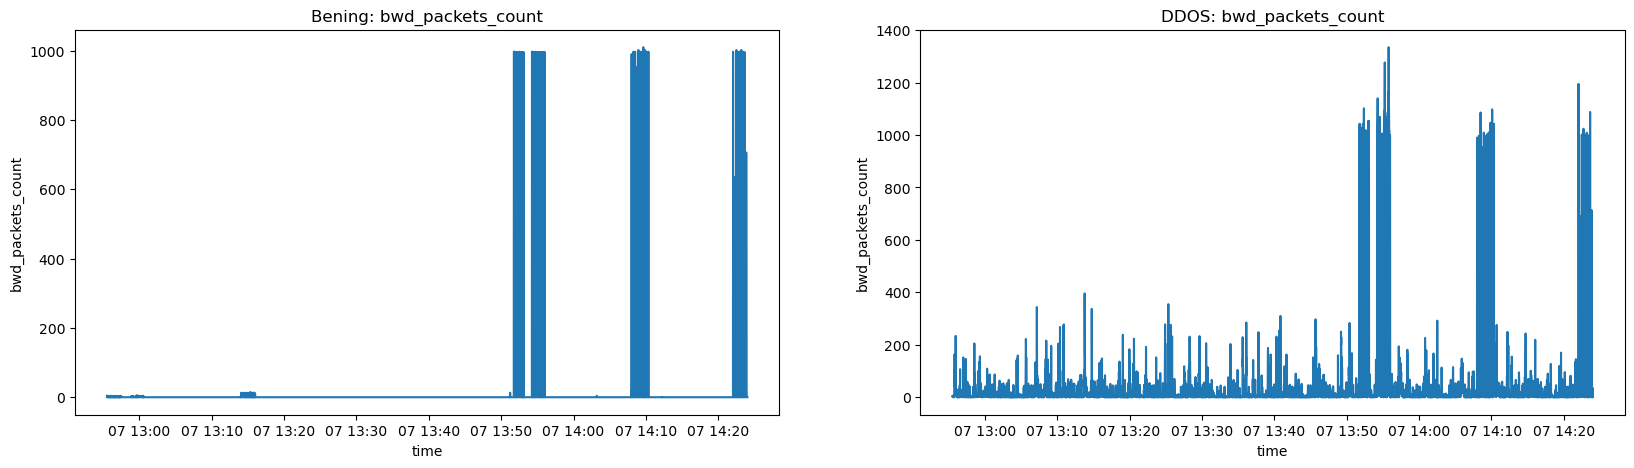

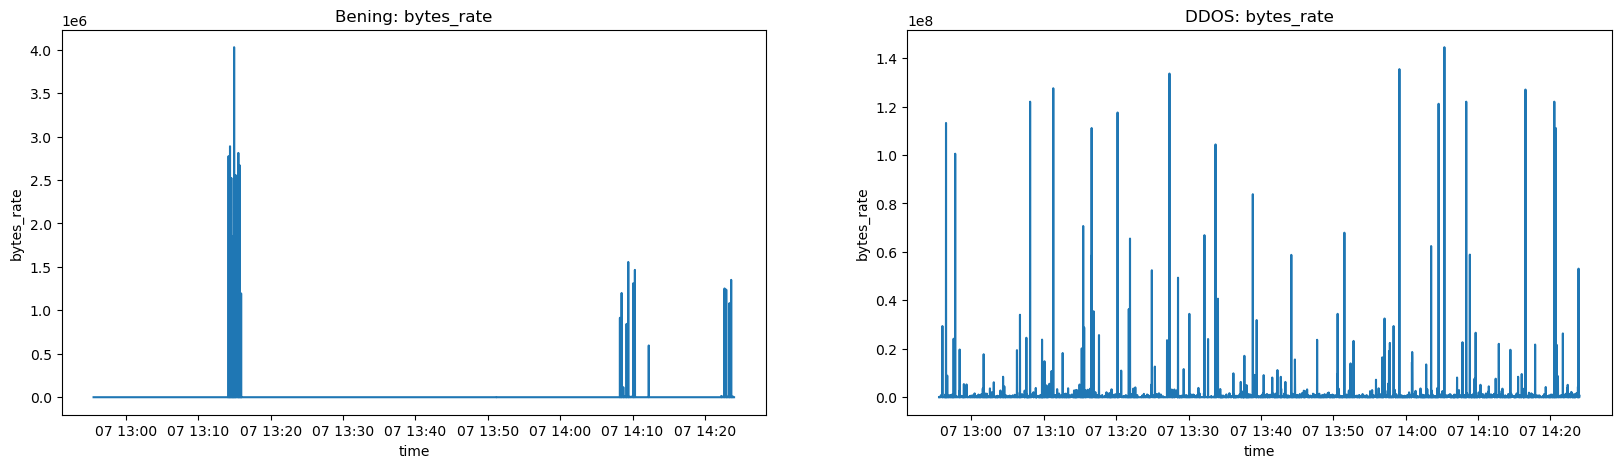

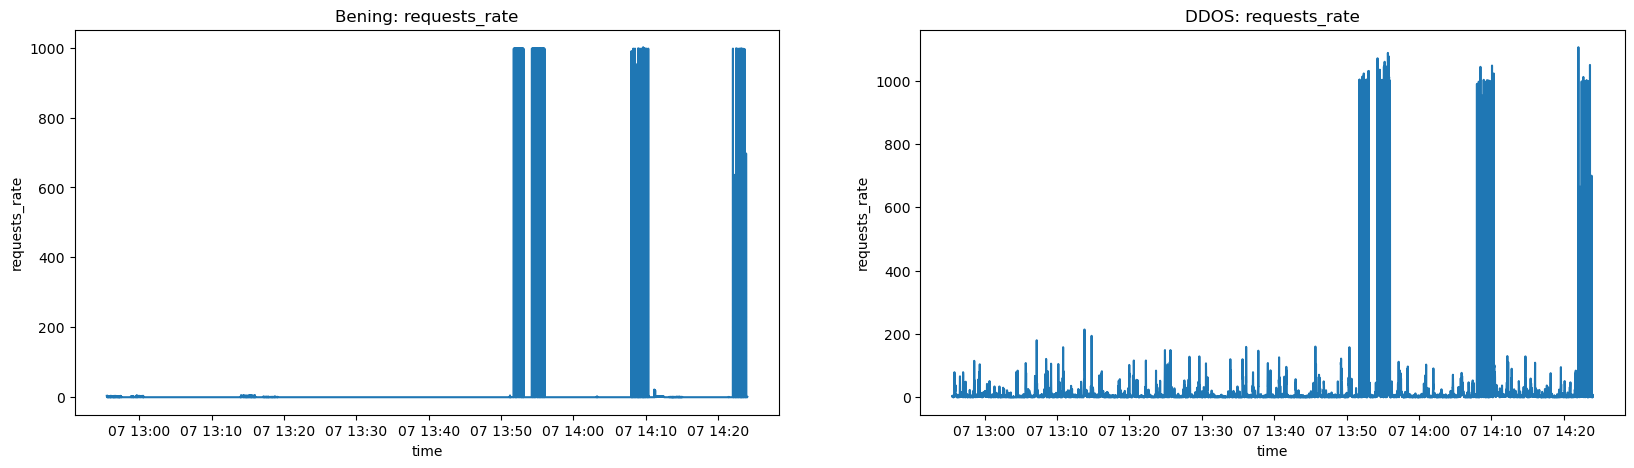

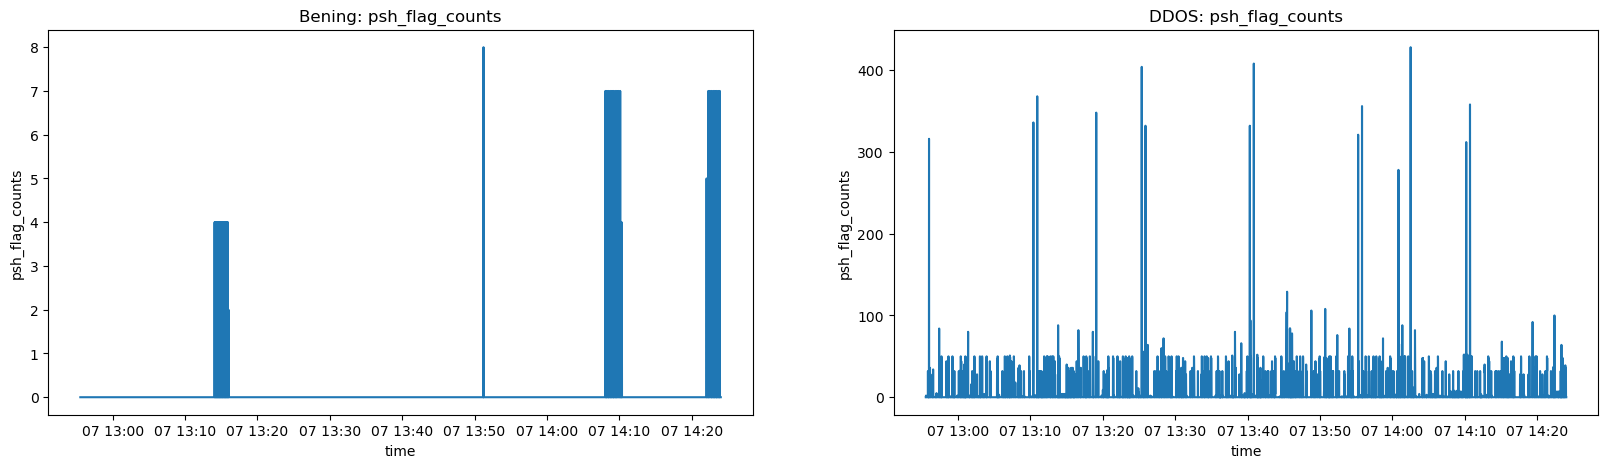

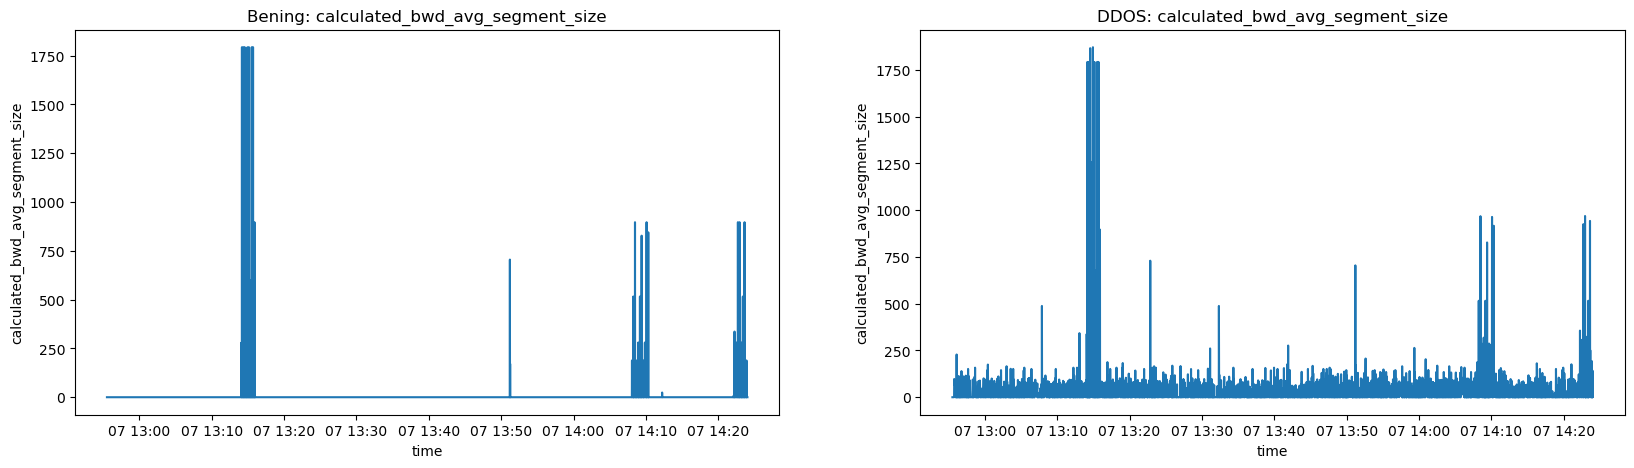

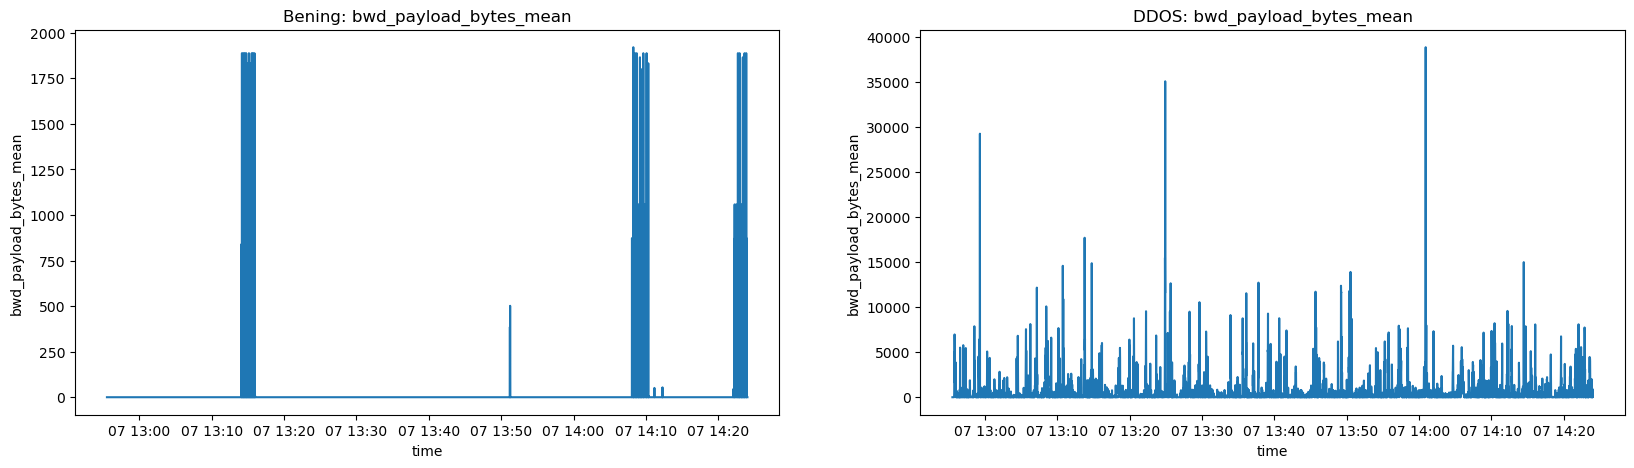

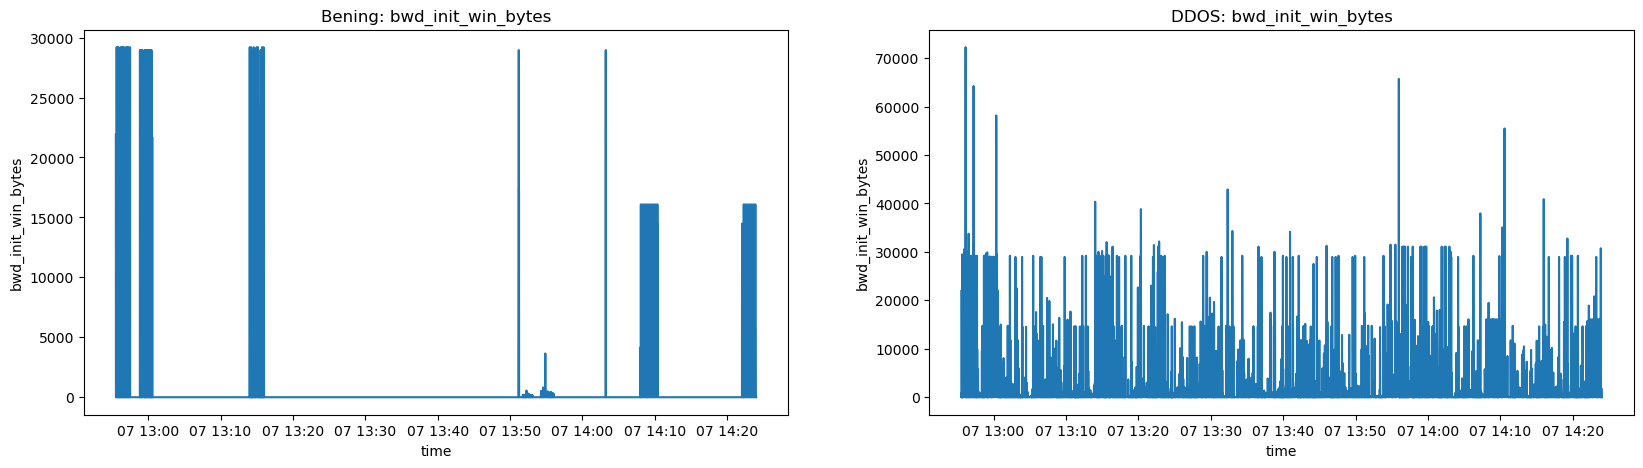

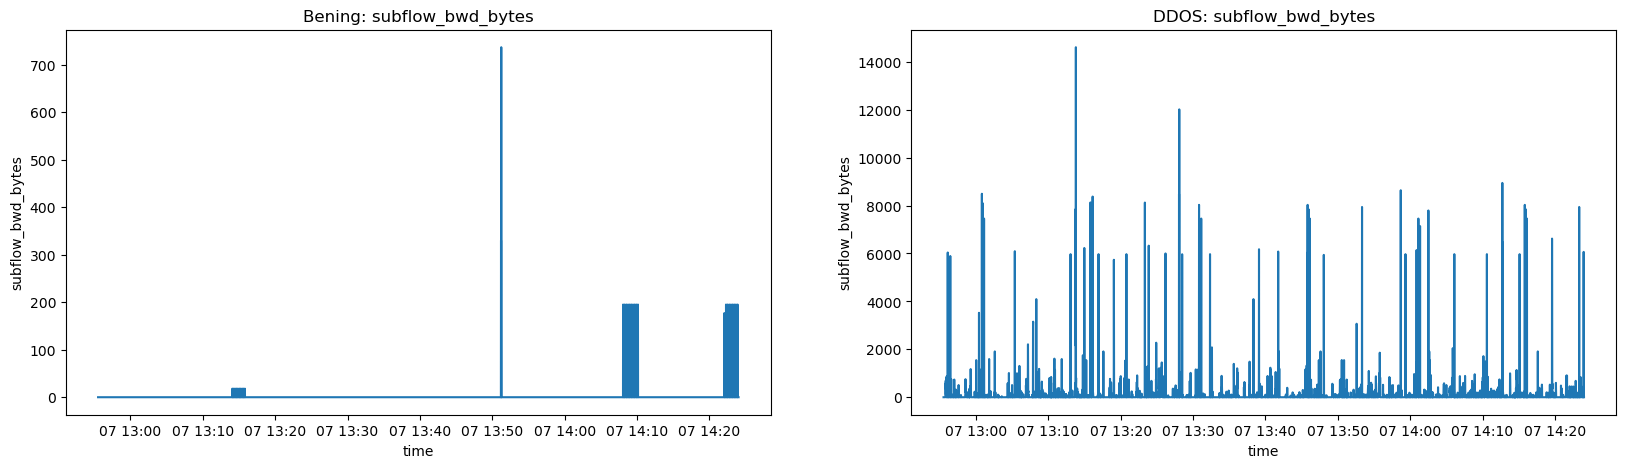

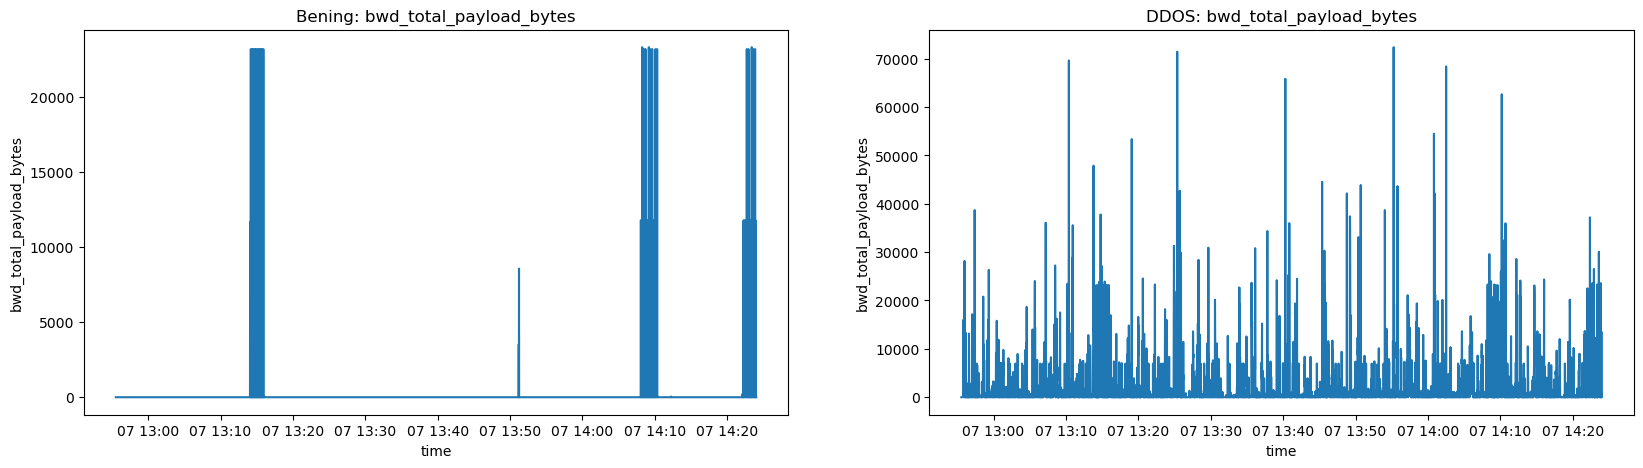

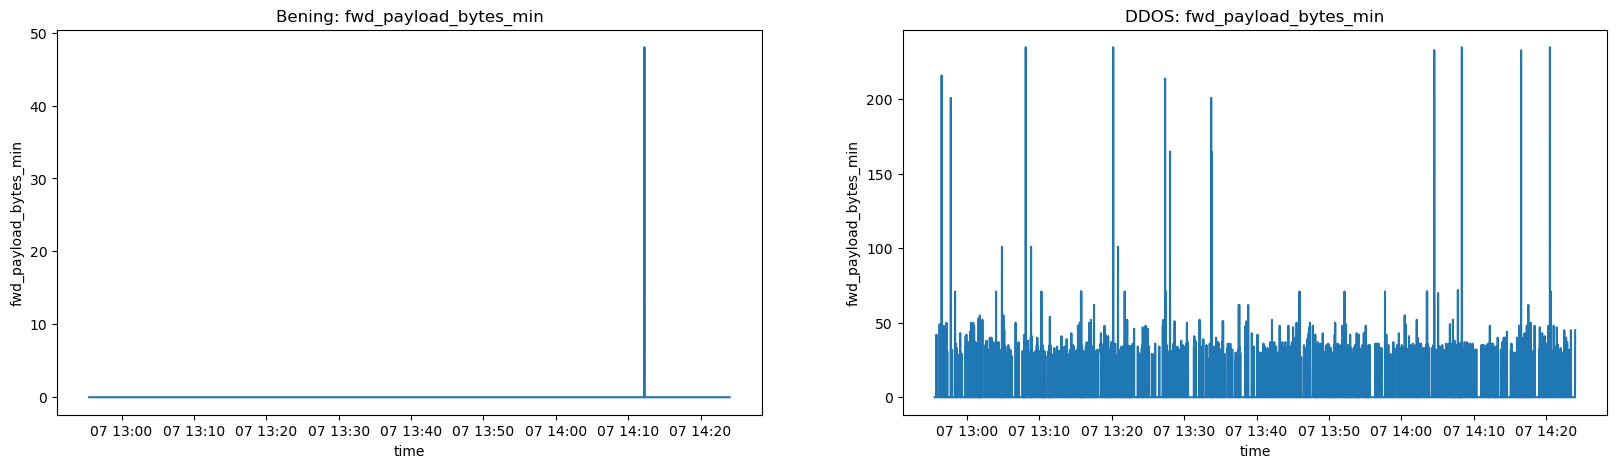

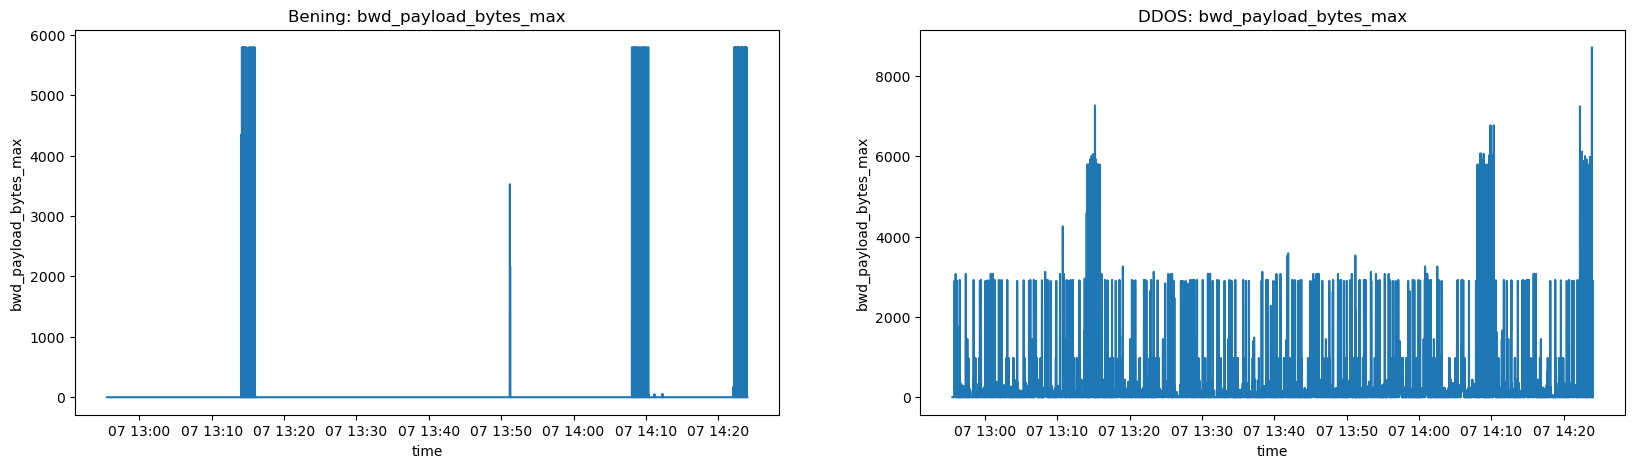

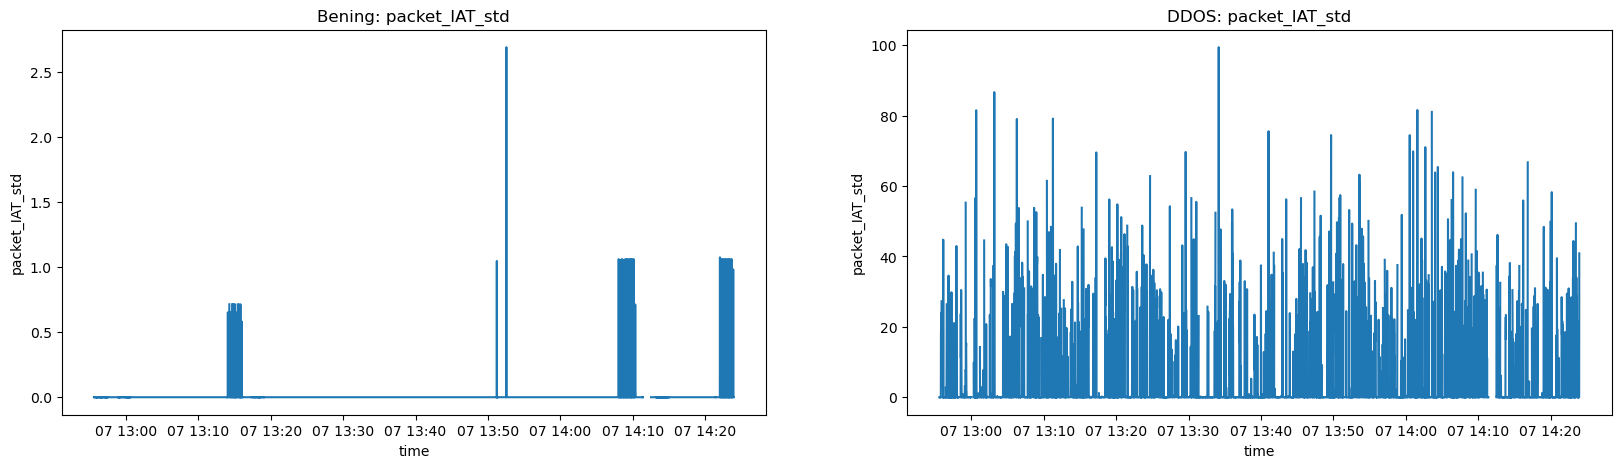

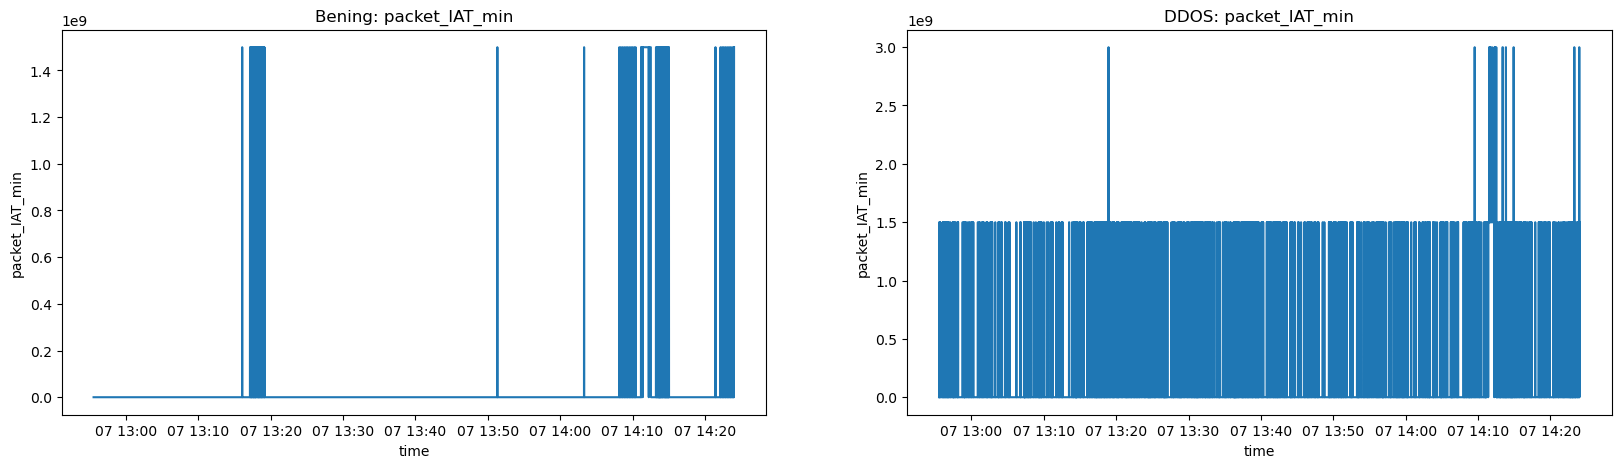

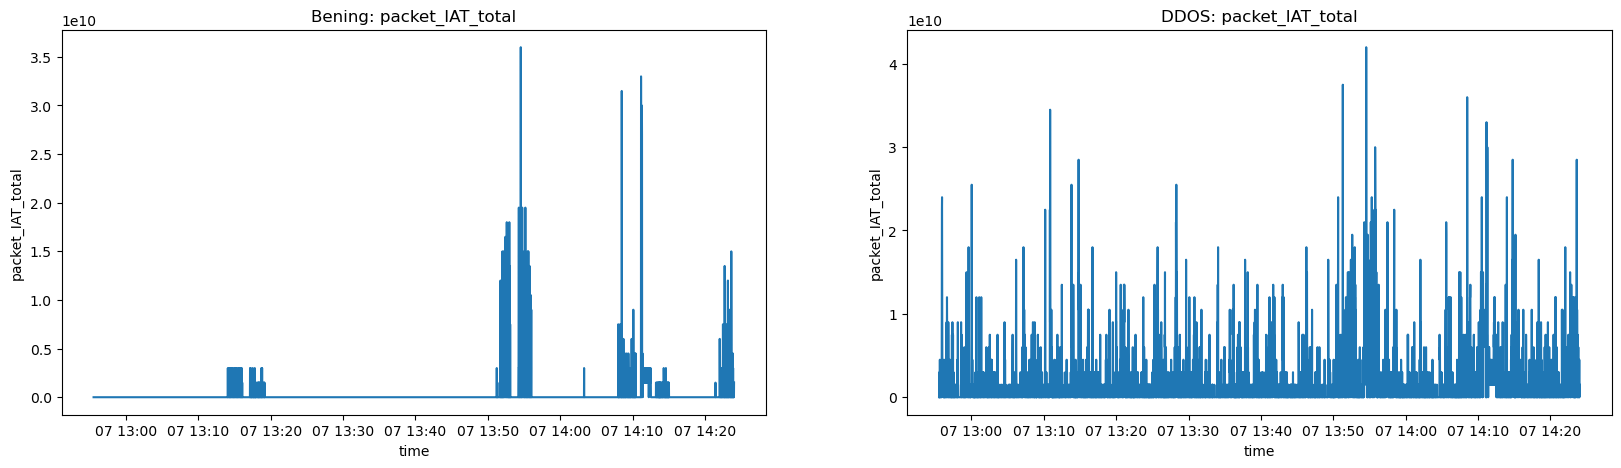

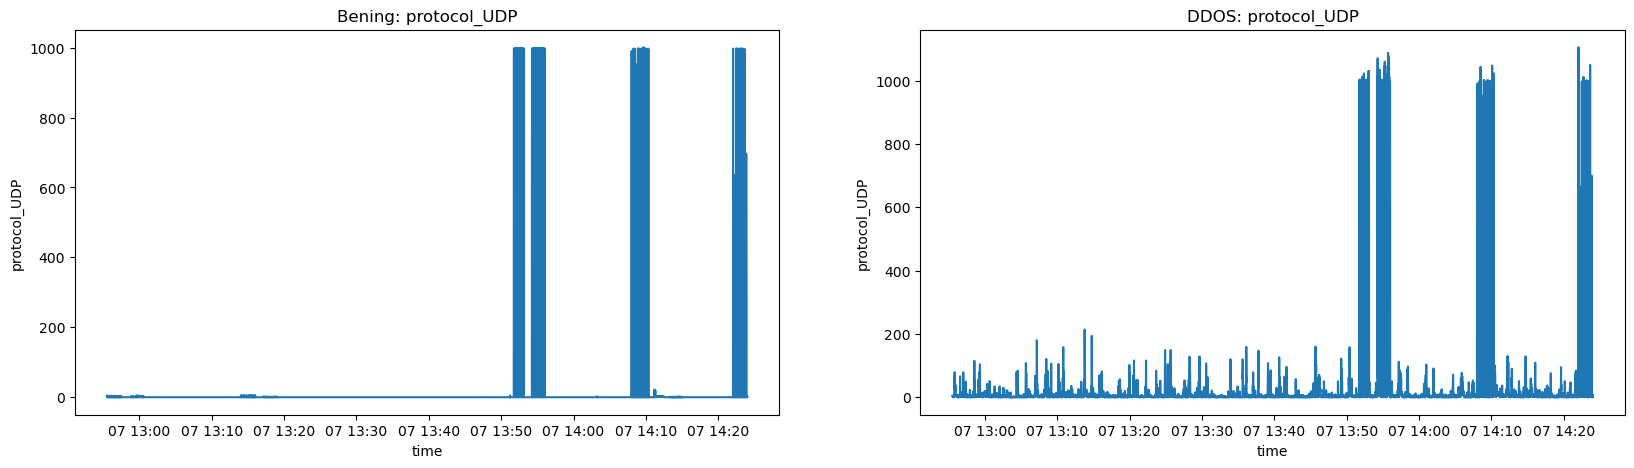

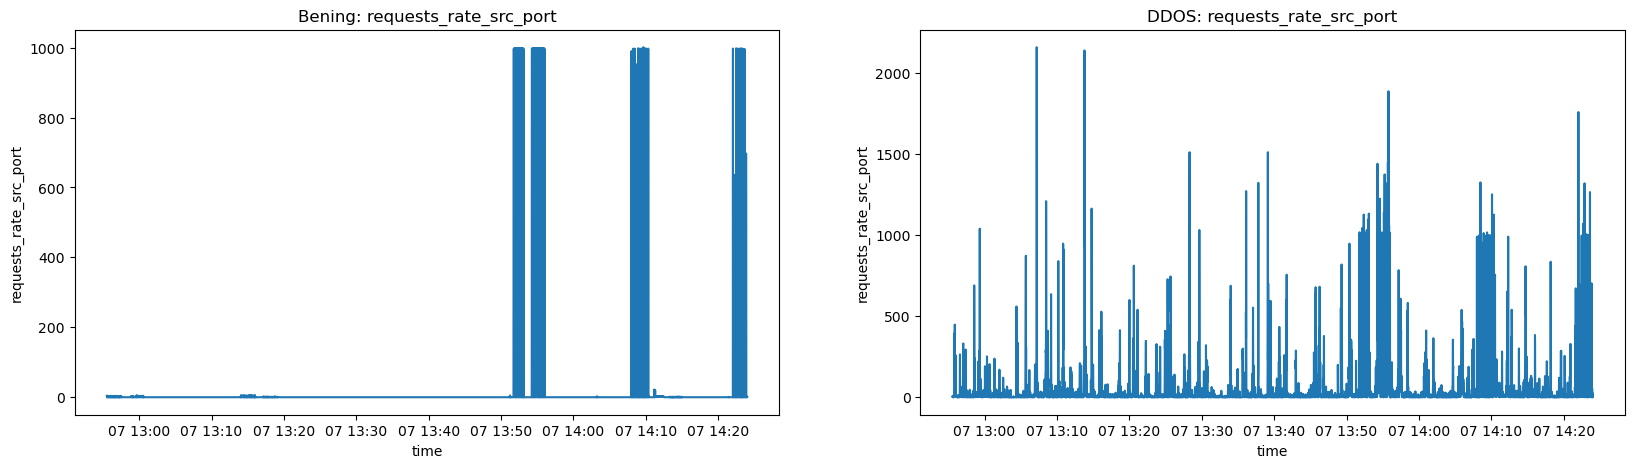

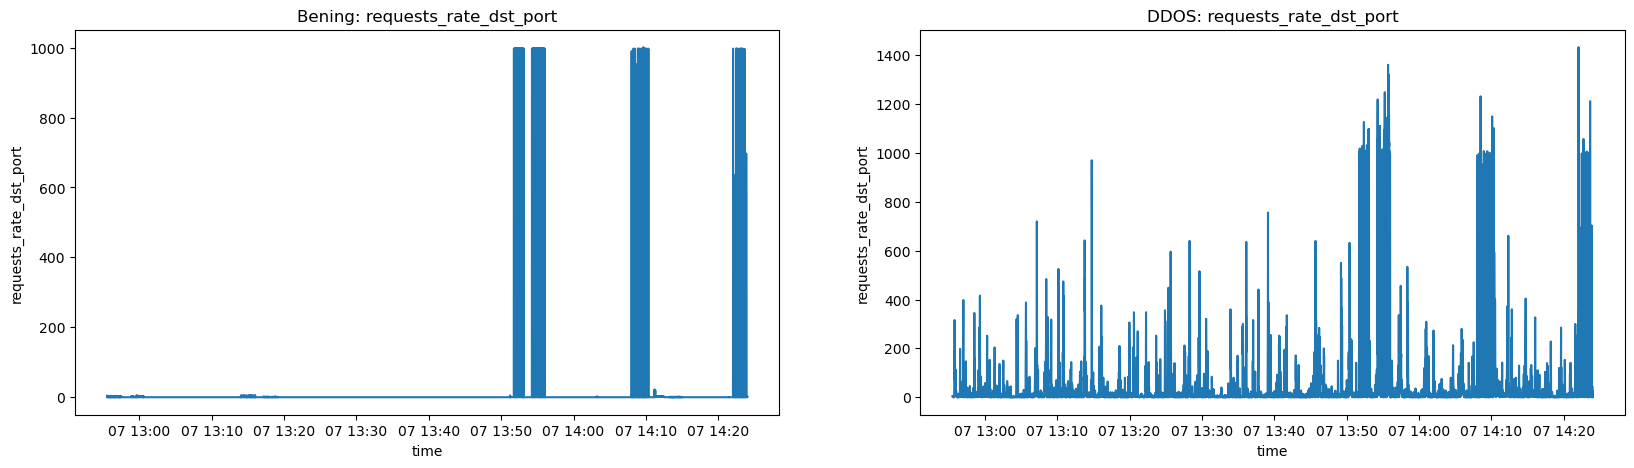

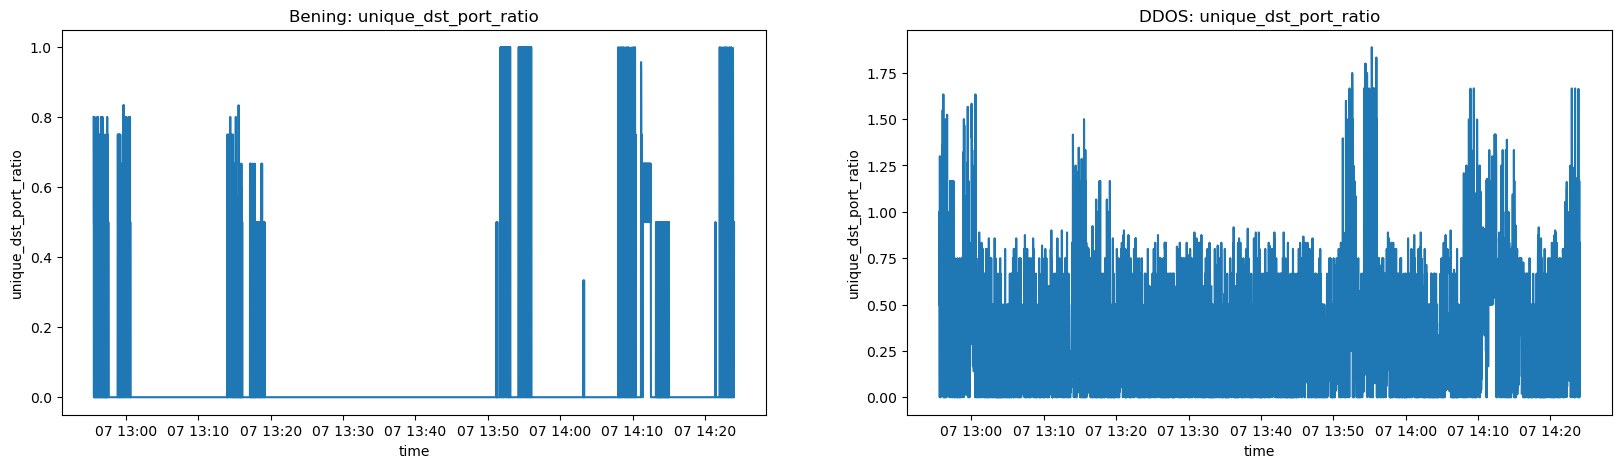

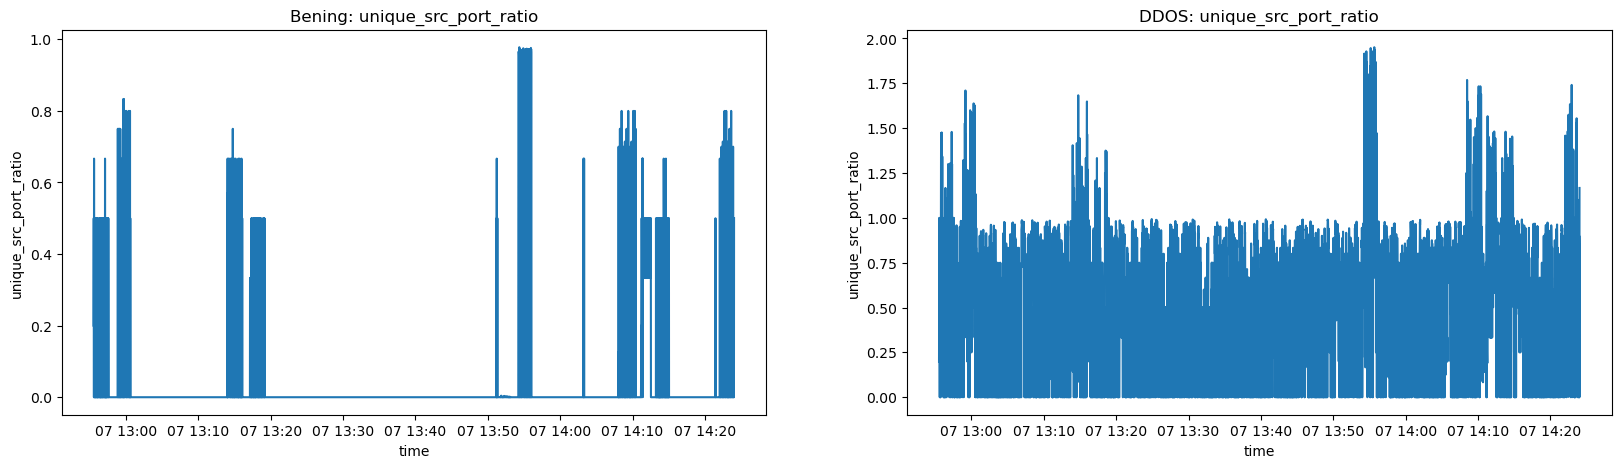

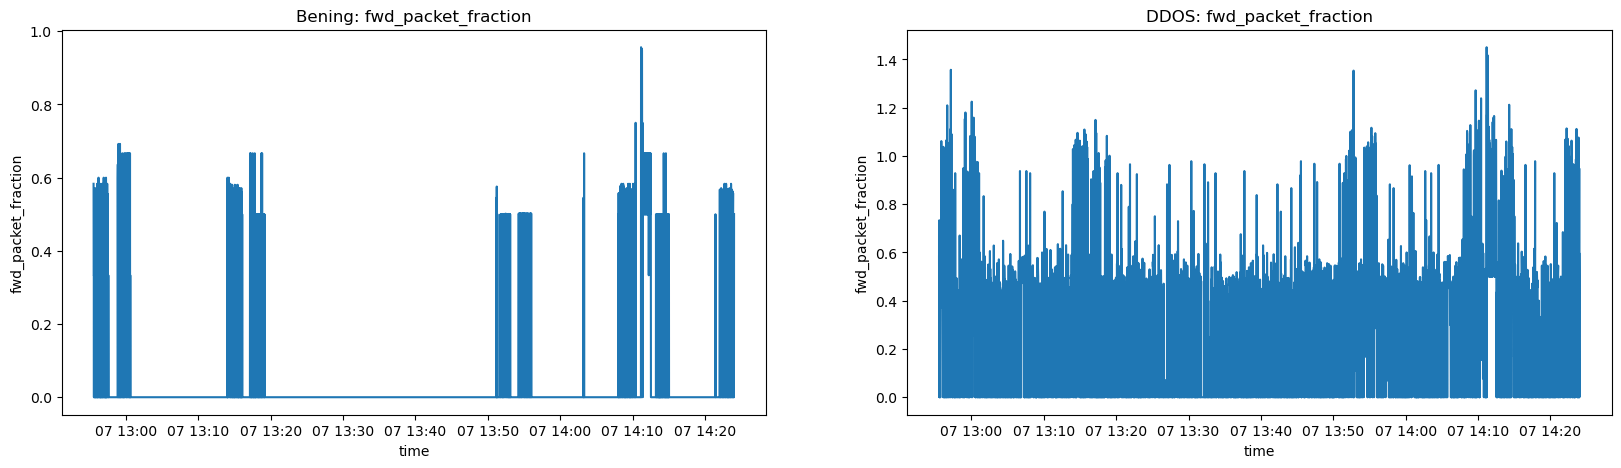

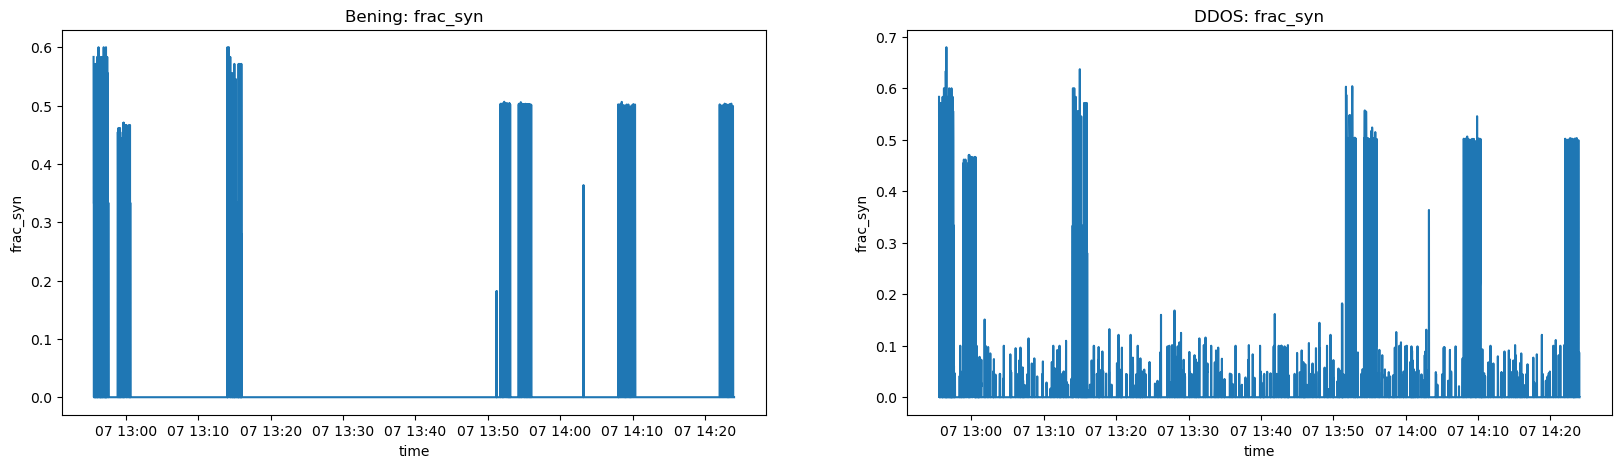

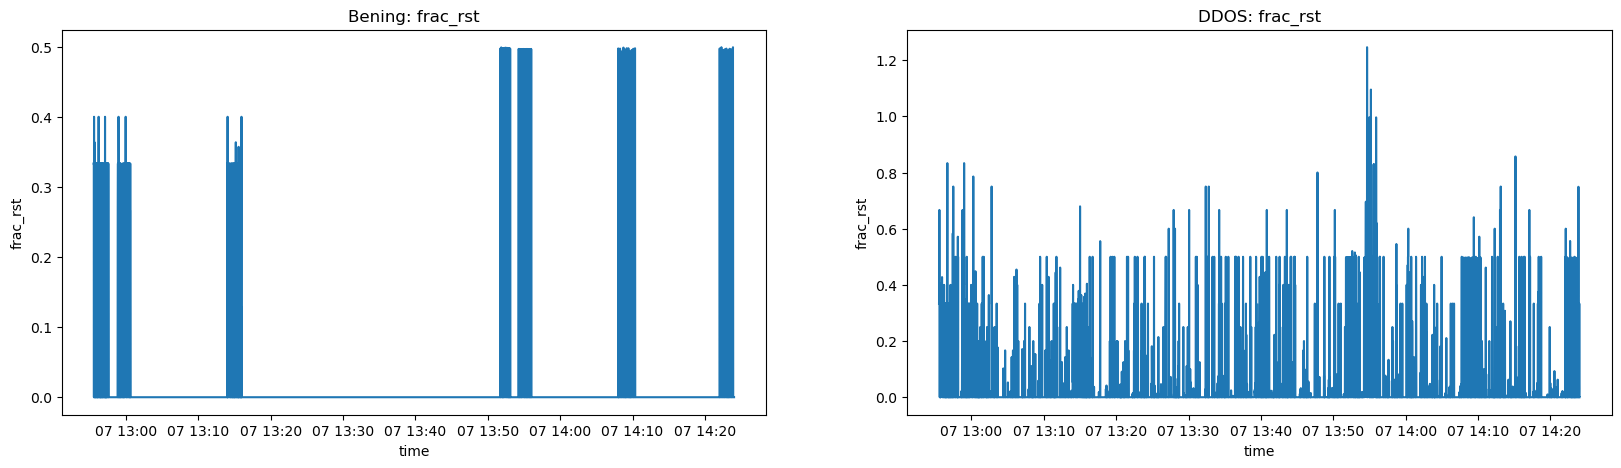

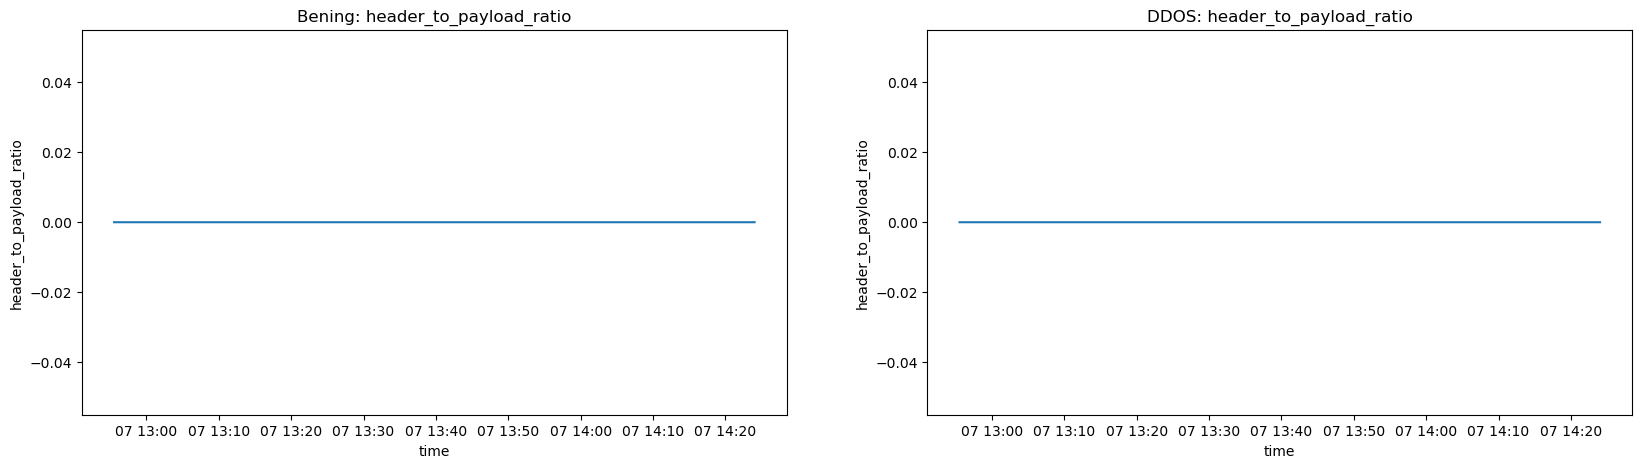

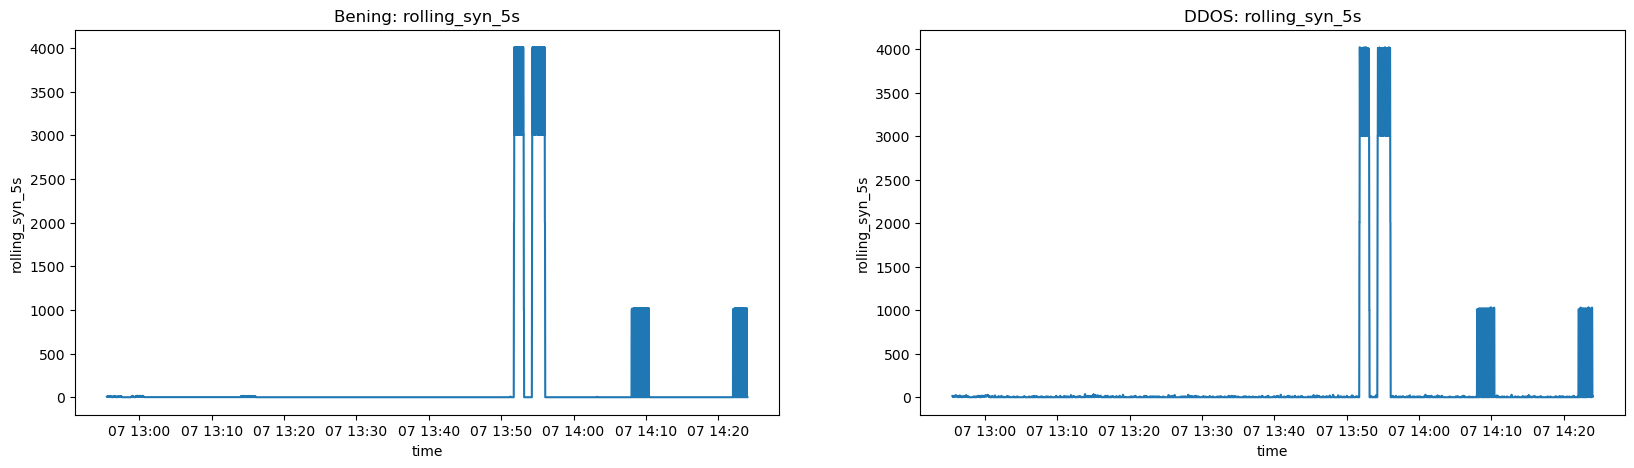

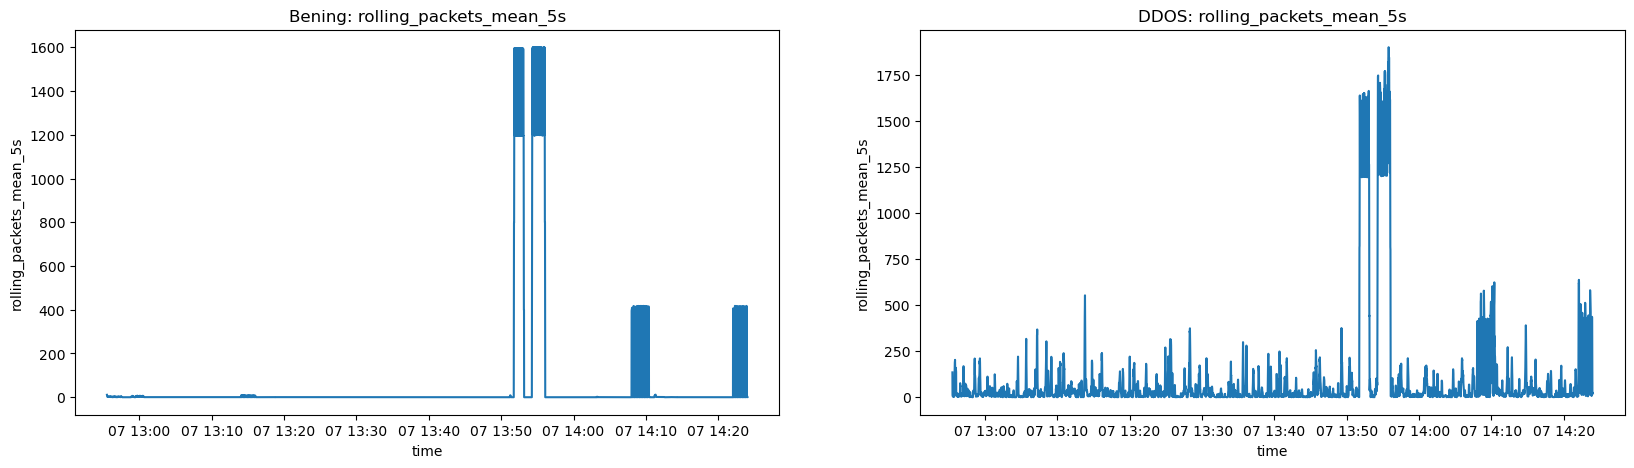

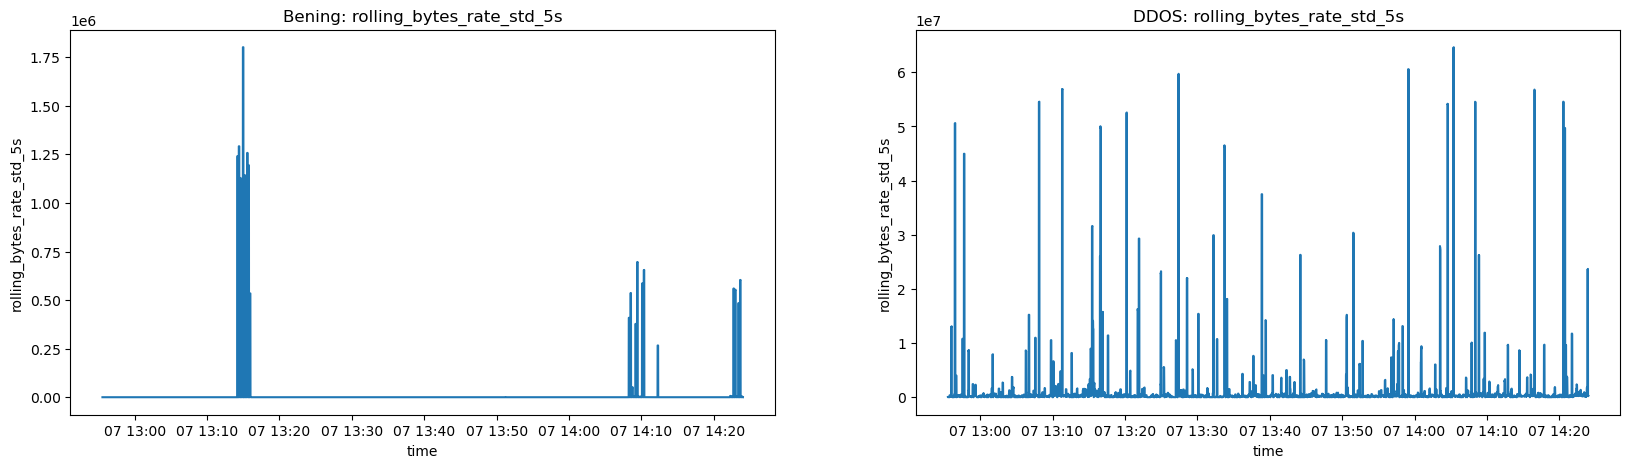

In [115]:
for feature in features:
    if bening_window.get(feature) is None:
        continue

     # Extract the start and end time from DDoS data
    start_time = ddos_subnet_agg.index.min()
    end_time = ddos_subnet_agg.index.max()

    # Select the corresponding time range from Bening traffic
    bening_window = bening_subnet_agg.loc[start_time:end_time]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(bening_window.index, ddos_subnet_agg[feature])
    ax1.set_title(f'Bening: {feature}')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('time')

    ax2.plot(ddos_subnet_agg.index, ddos_subnet_agg[feature] + bening_window[feature])
    ax2.set_title(f'DDOS: {feature}')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('time')

plt.show()

(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
(28972, 1)
Original Signal Length: 28972
Resampled Approximation Length: 28972
Filter length: 2


/var/folders/bm/wq_7x62n7_16_jwz7q1h_v440000gn/T/ipykernel_72916/990396046.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


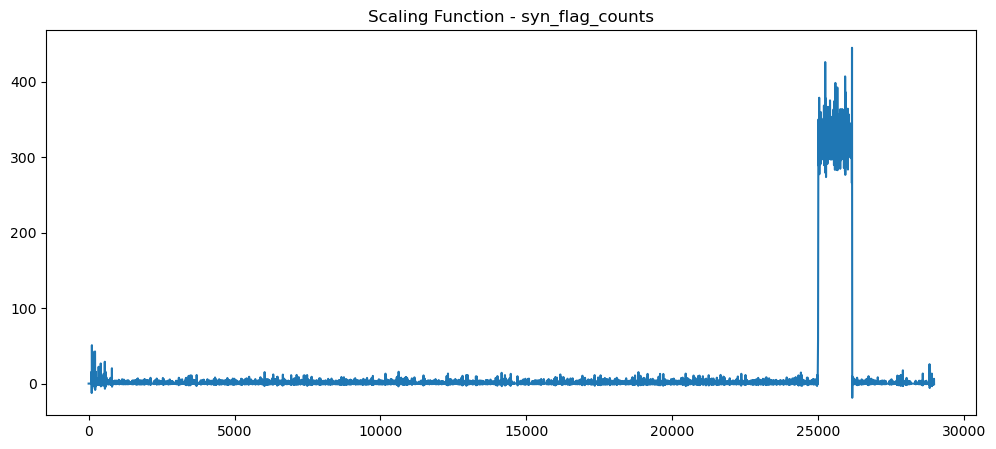

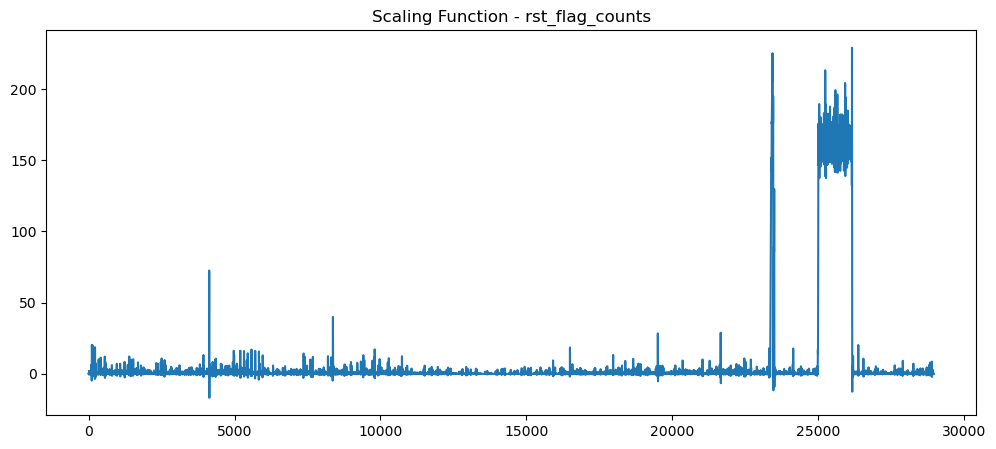

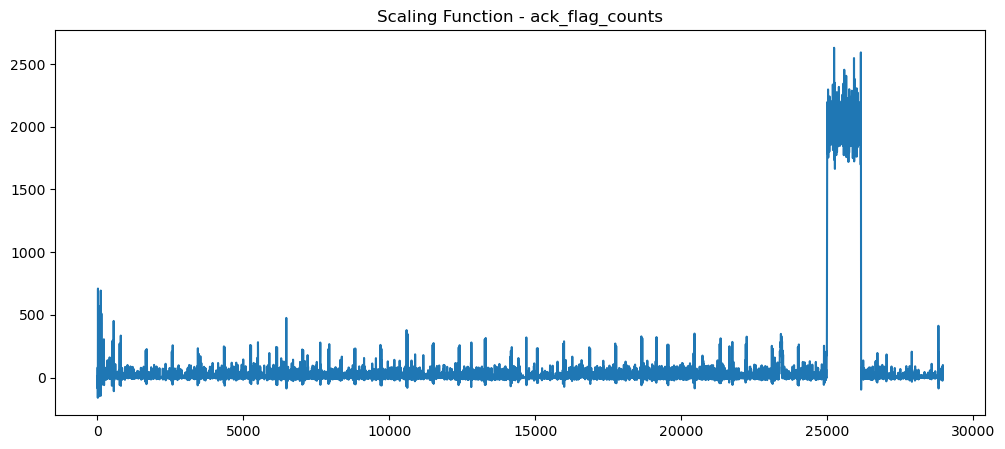

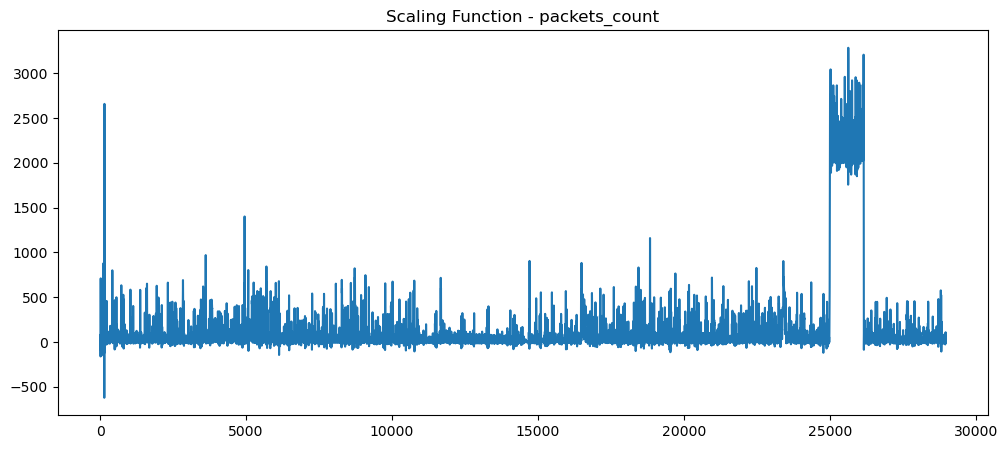

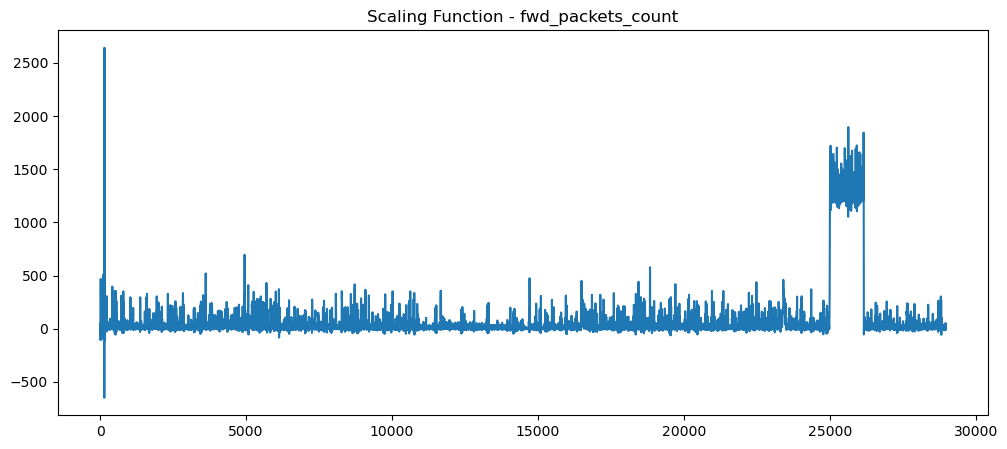

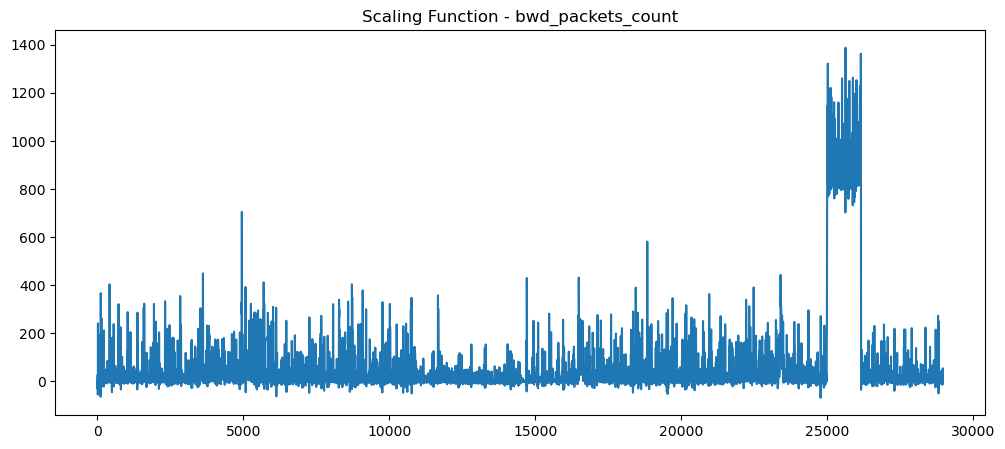

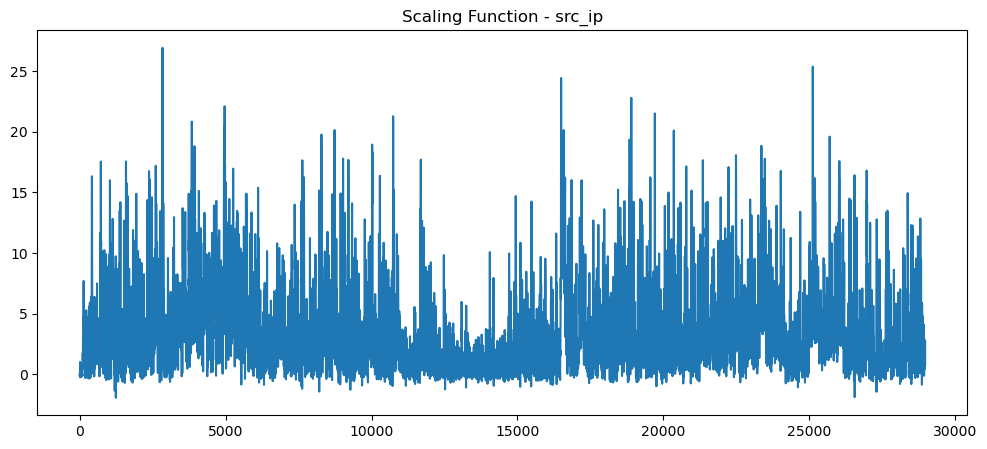

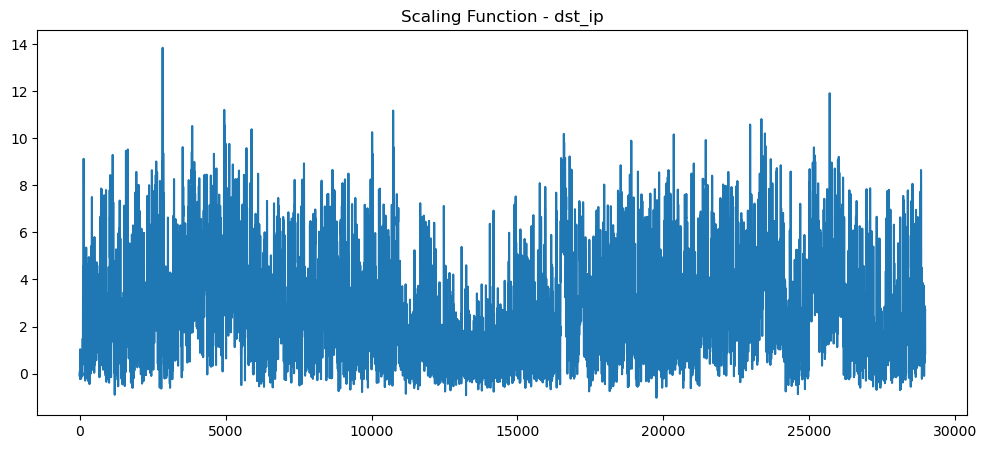

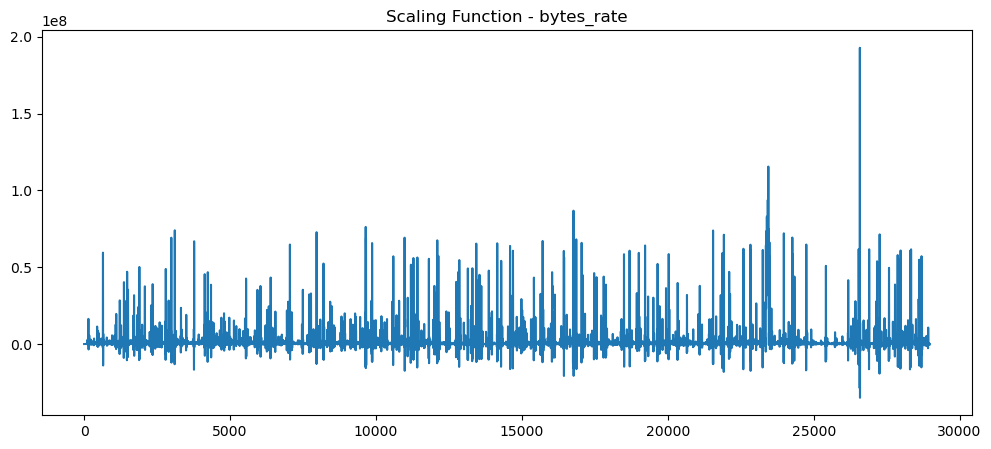

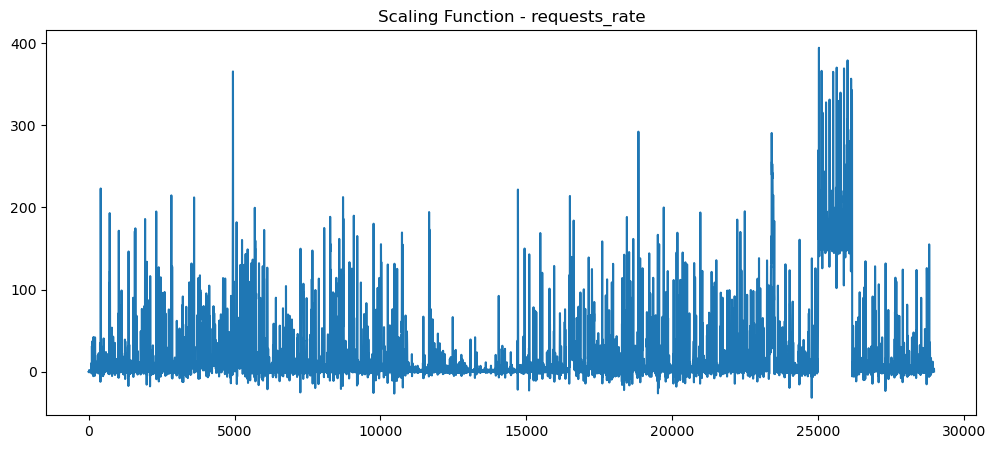

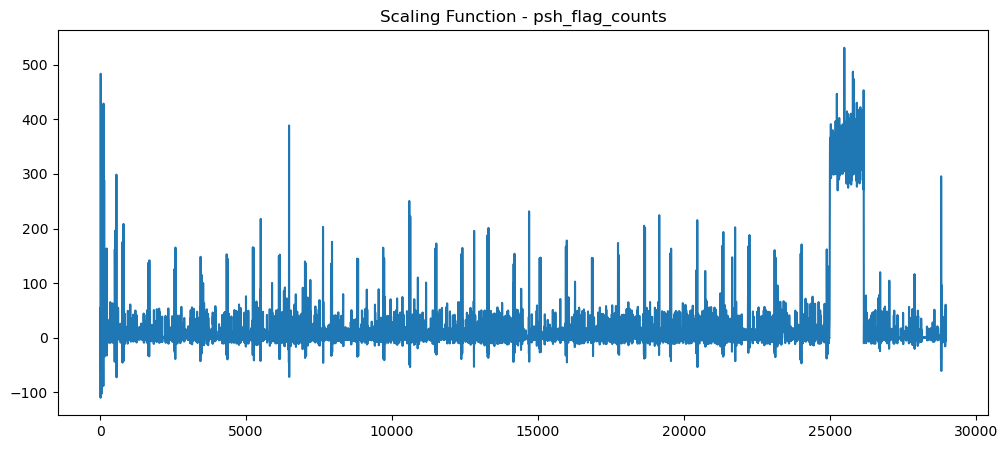

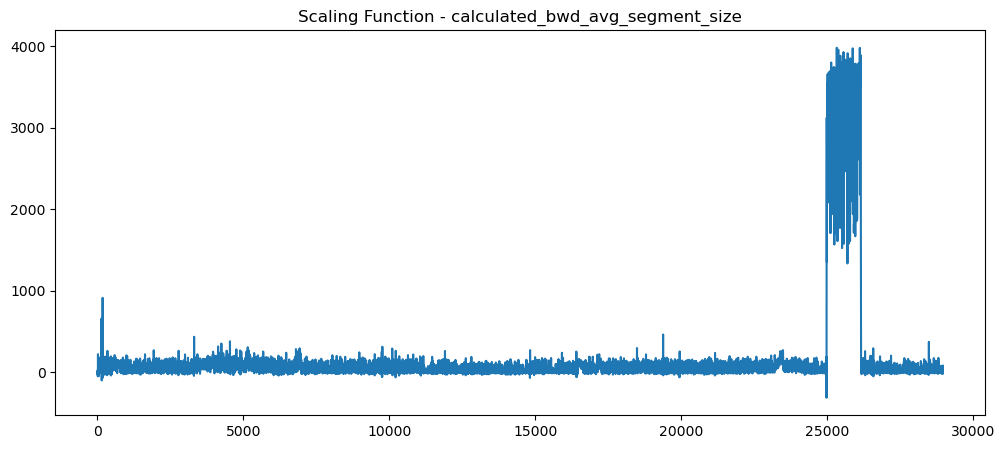

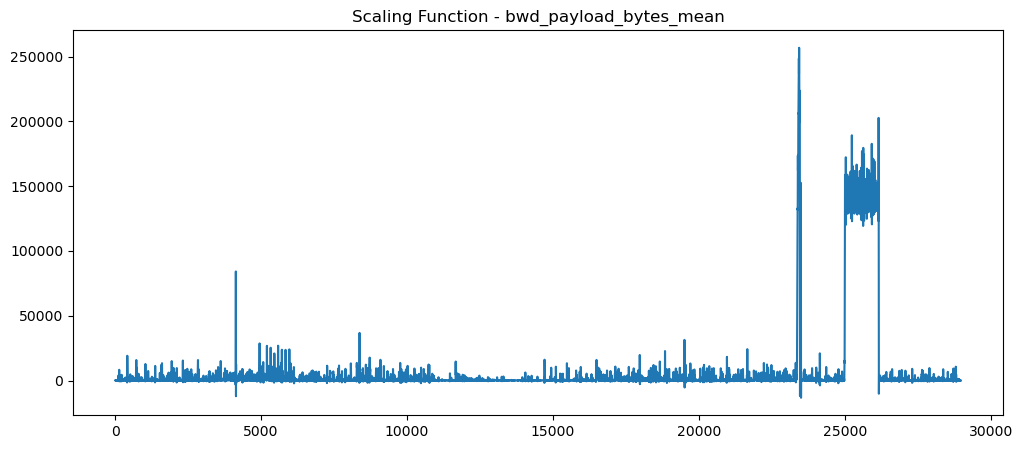

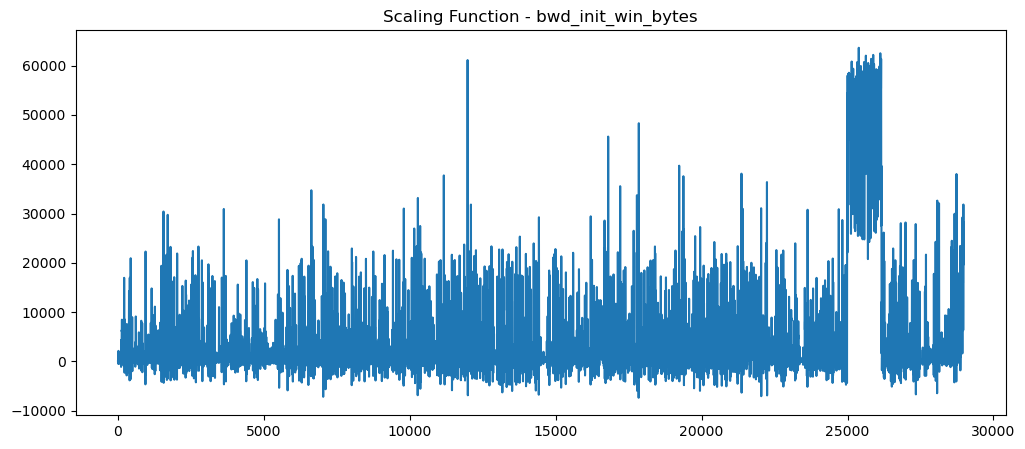

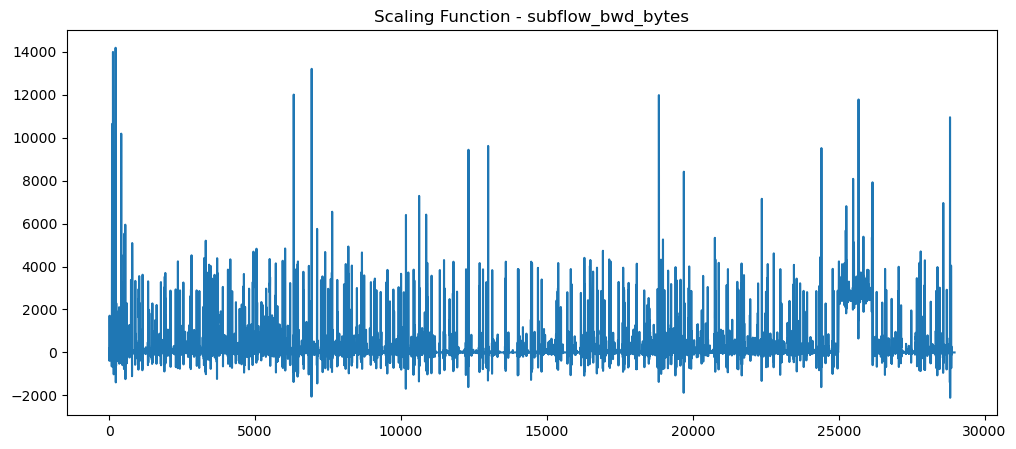

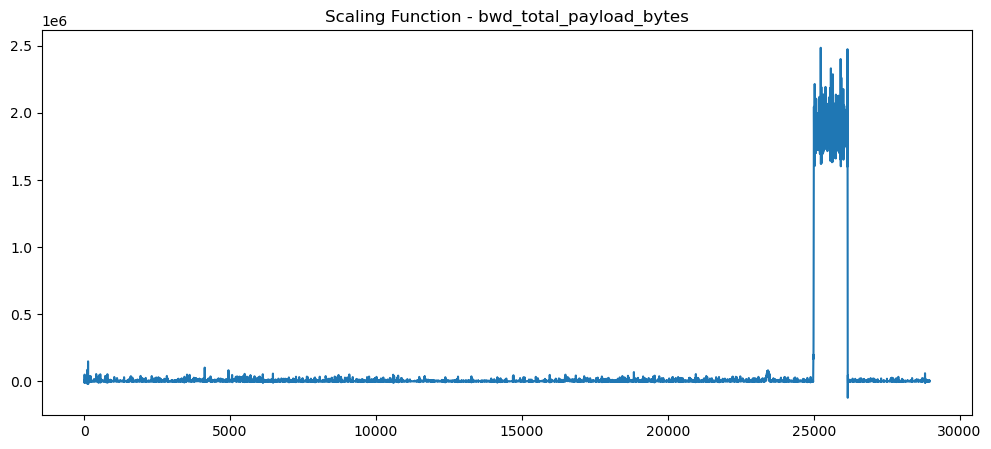

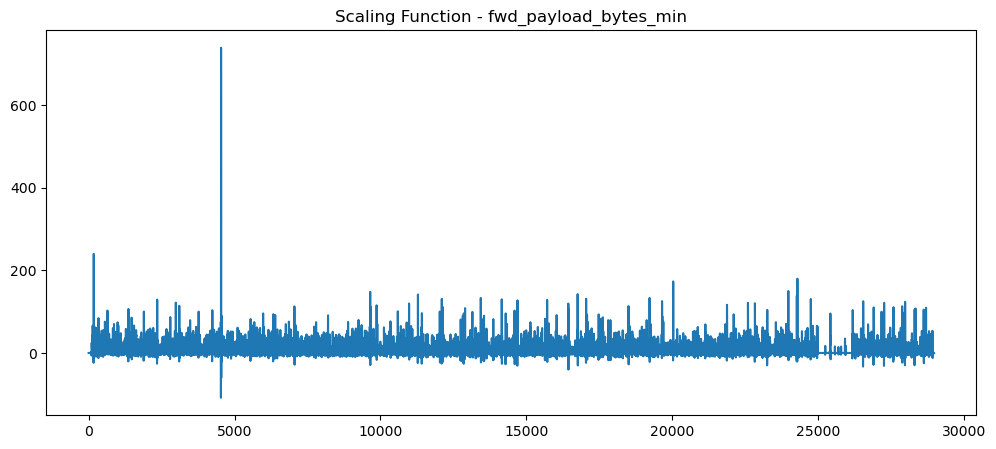

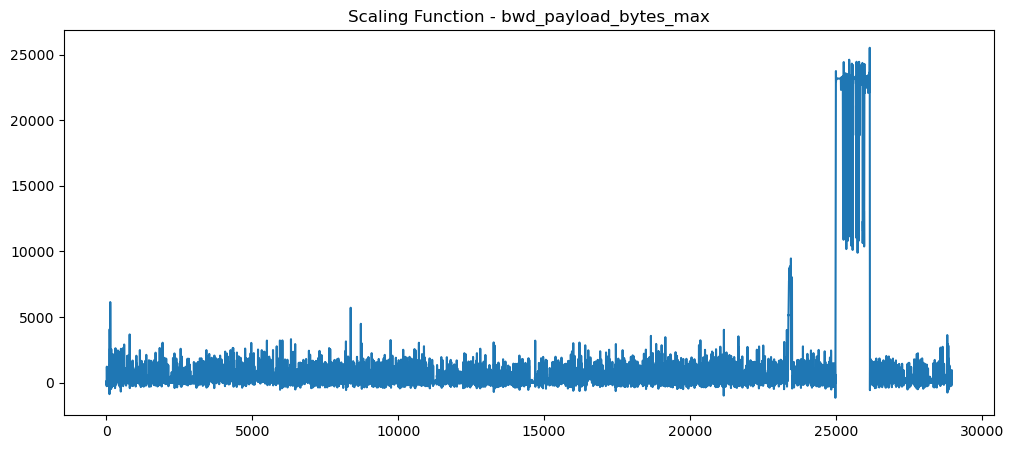

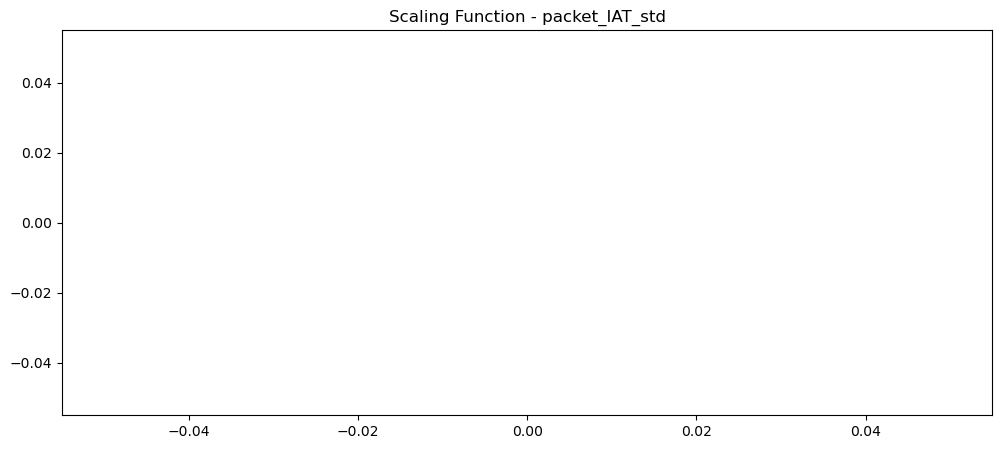

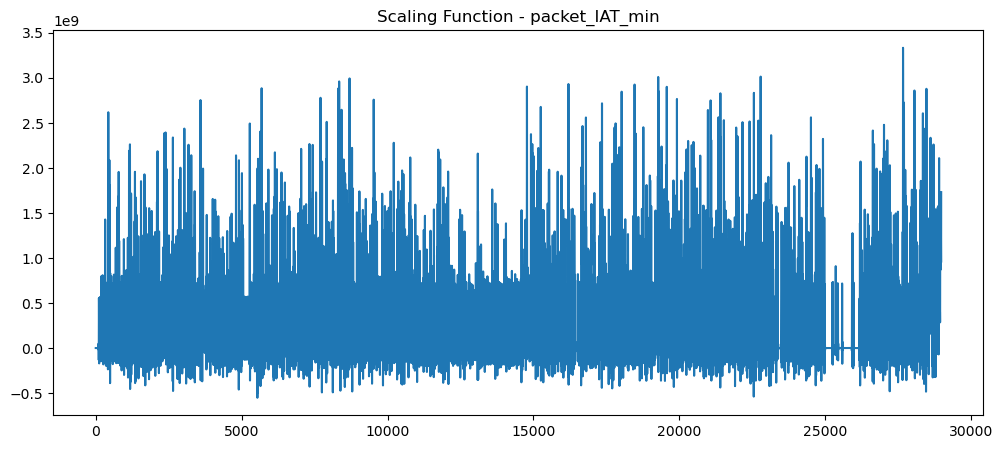

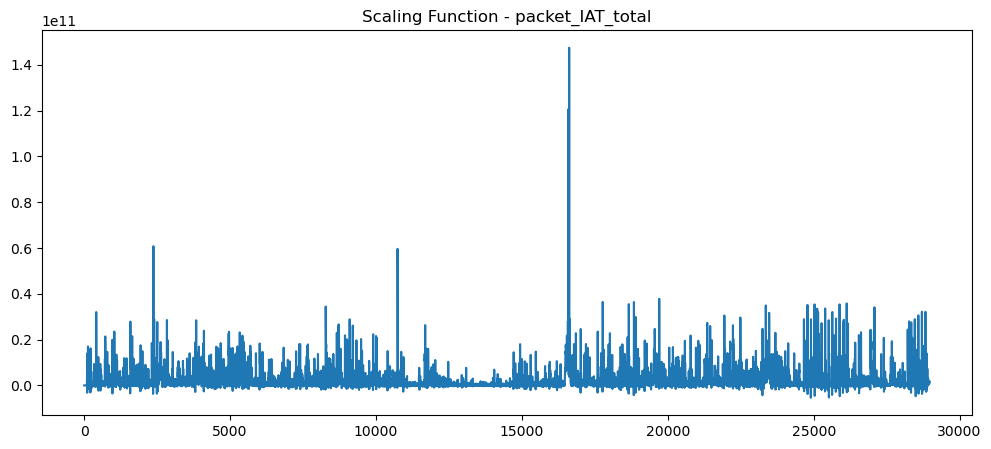

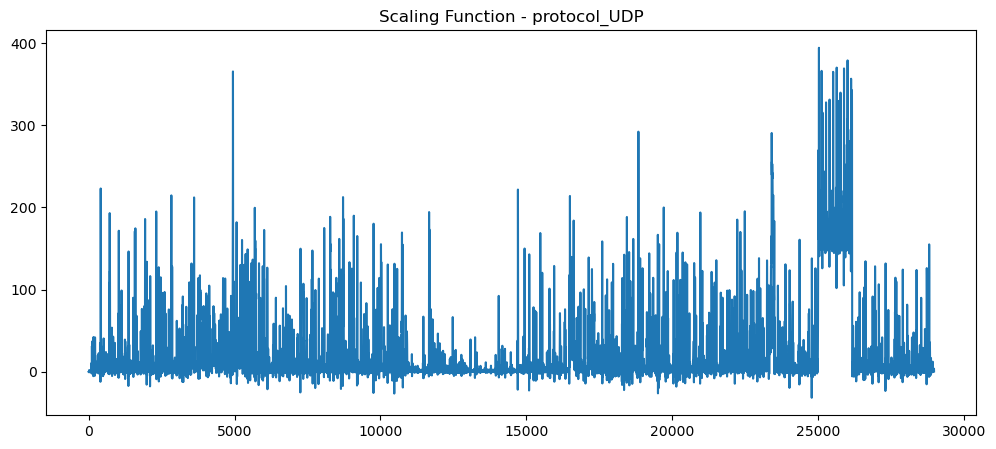

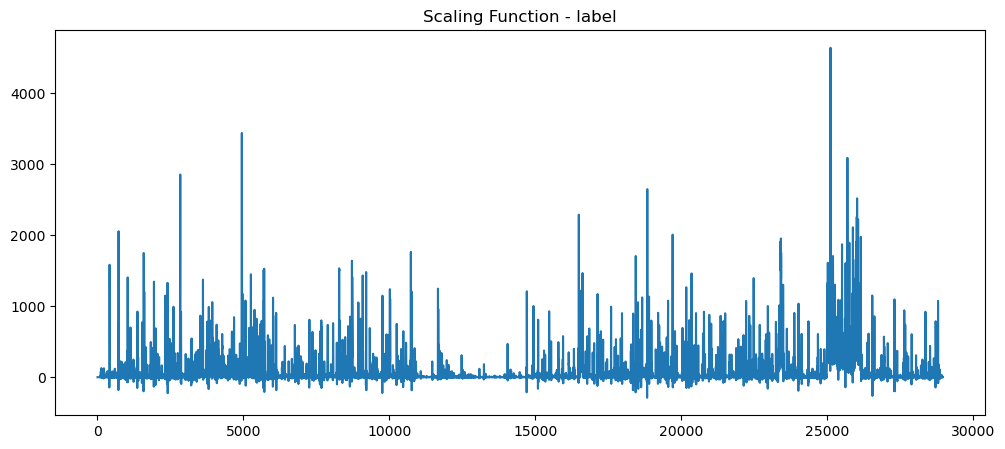

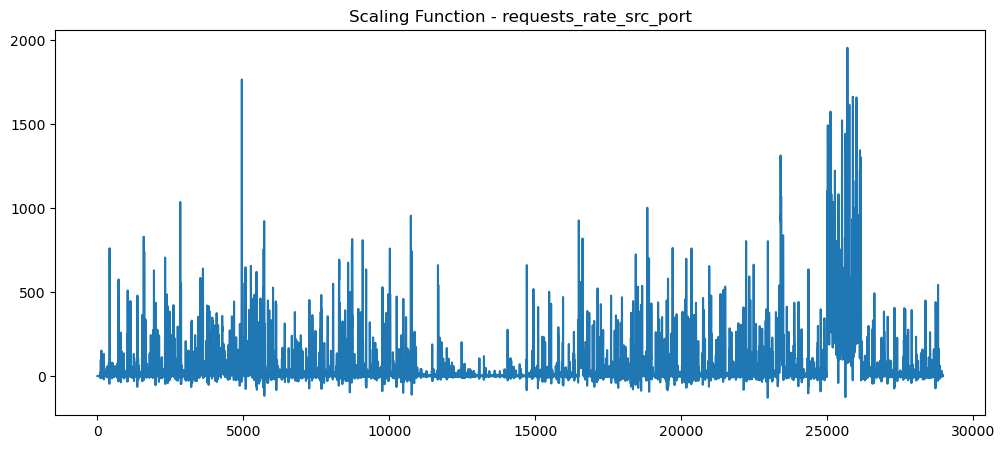

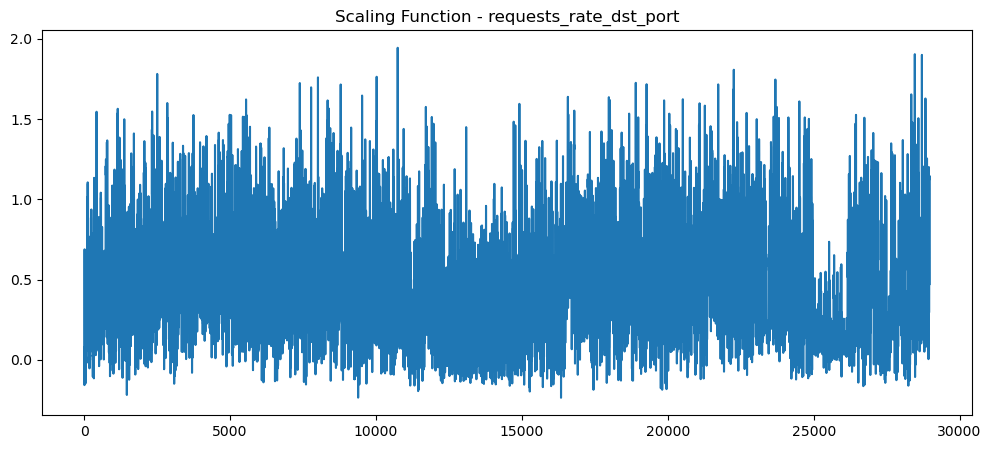

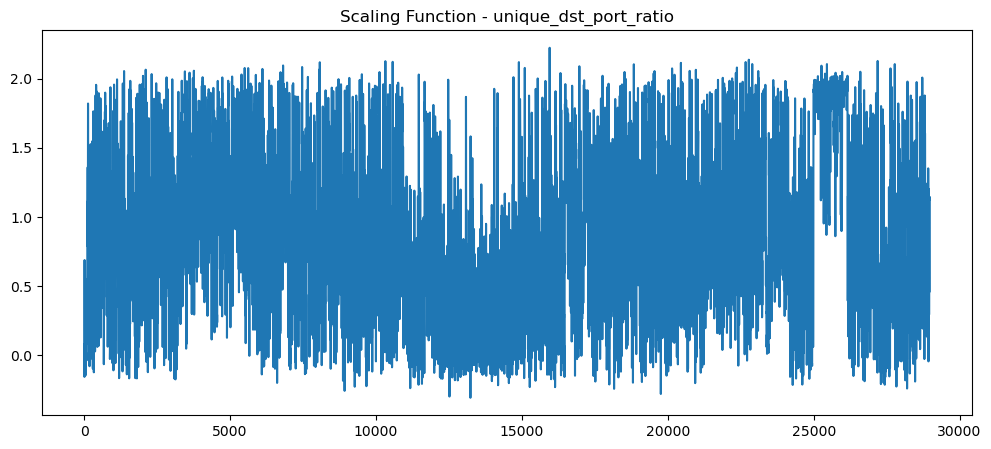

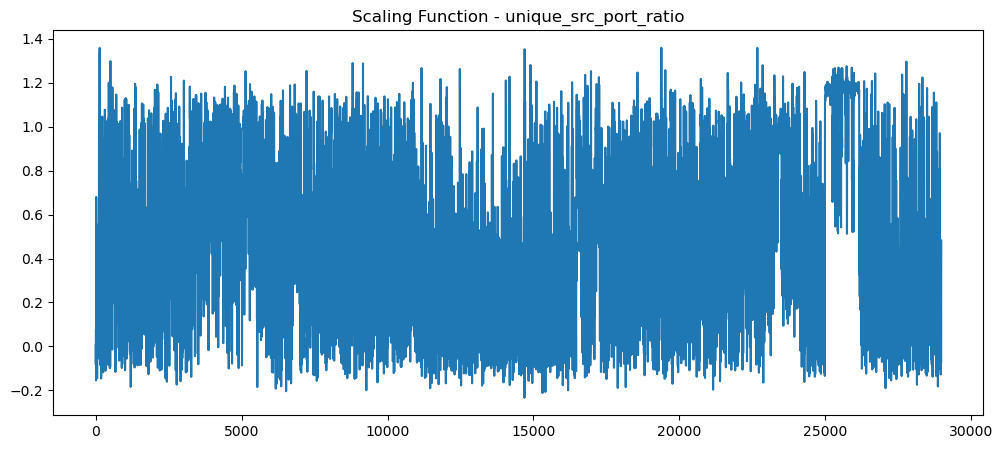

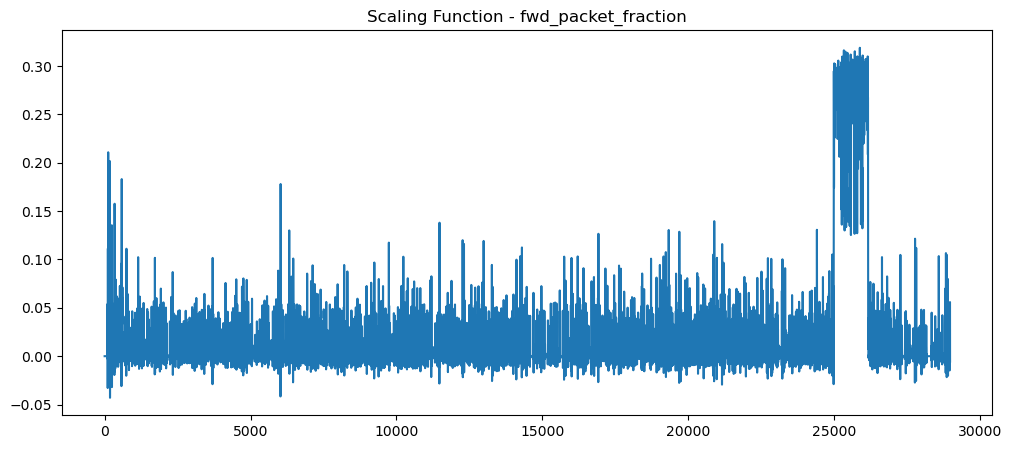

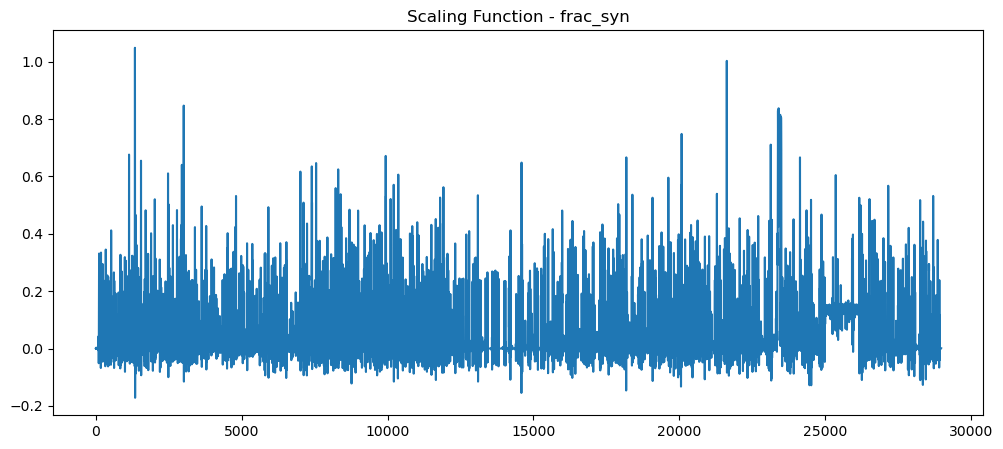

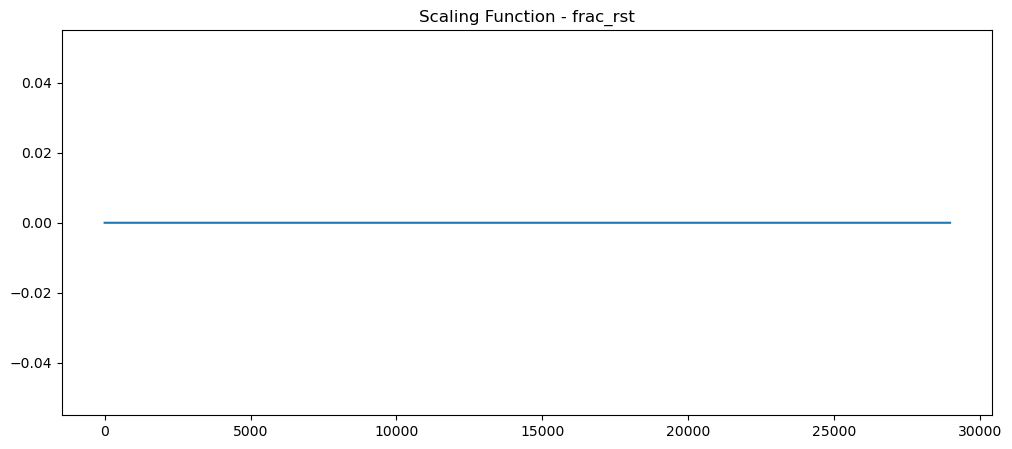

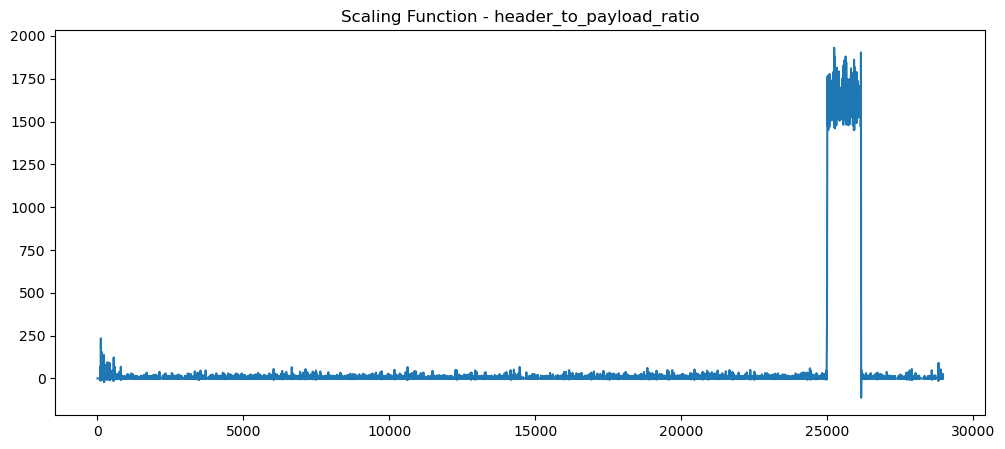

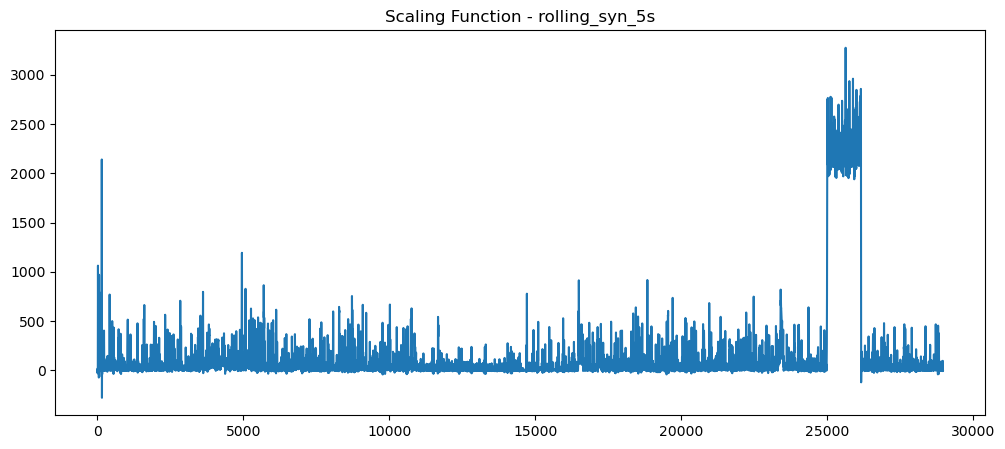

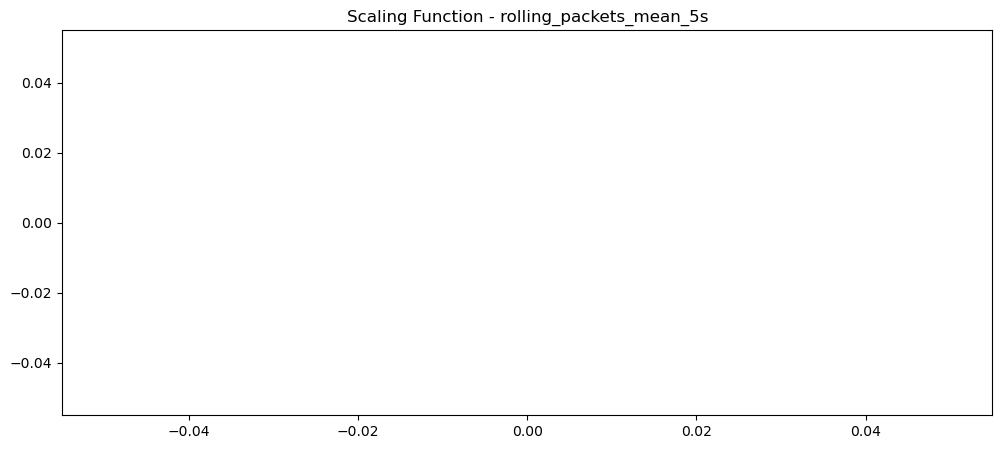

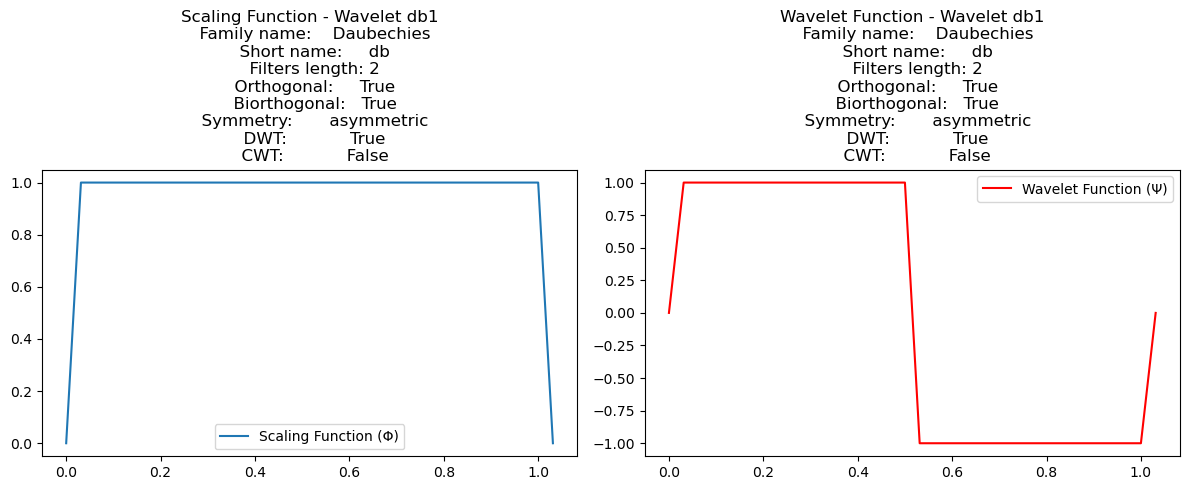

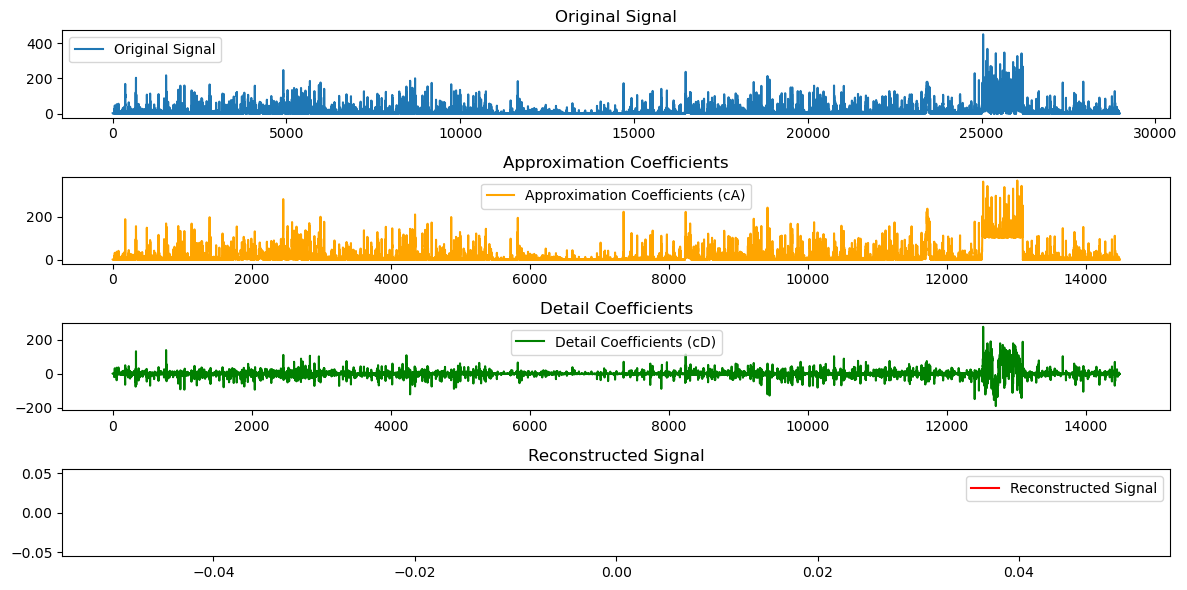

datetime
2017-07-07 07:59:50    1
2017-07-07 07:59:51    1
2017-07-07 07:59:52    1
2017-07-07 07:59:53    1
2017-07-07 07:59:54    1
                      ..
2017-07-07 16:02:37    1
2017-07-07 16:02:38    1
2017-07-07 16:02:39    1
2017-07-07 16:02:40    1
2017-07-07 16:02:41    1
Freq: s, Name: label, Length: 28972, dtype: int64

In [169]:
import pywt
from scipy.interpolate import interp1d

wavelet = 'db1'
cA, cD = pywt.dwt(combined_data_agg['requests_rate'].values, wavelet)
reconstructed_signal = pywt.idwt(cA, cD, wavelet)

approximations = []
for column in combined_data_agg.drop(columns=['label']).columns:
    coeffs = pywt.wavedec(combined_data_agg[column].values, 'coif5', level=2)
    approximations.append(coeffs[0])

def upsample(length, coef):
    # Define original and target indices
    original_indices = np.linspace(0, length-1, num=len(coef))  # Existing points
    target_indices = np.arange(length)  # Target full-length points

    # Resample using linear interpolation
    return interp1d(original_indices, coef, kind='cubic')(target_indices)
    #return np.interp(target_indices, original_indices, coef)

approx_features = np.empty(shape=(combined_data_agg.shape[0], 1))
for i, approx in enumerate(approximations):
    col = combined_data_agg.columns[i]
    plt.figure(figsize=(12, 5))
    upsampled = upsample(combined_data_agg.shape[0], approx)
    print(upsampled.reshape(-1, 1).shape)
    plt.plot(upsampled, label='Scaling Function (Φ)')
    plt.title(f'Scaling Function - {col}')

    approx_features = np.column_stack([approx_features, upsampled])

cA_resampled = upsample(len(combined_data_agg['requests_rate']), coeffs[0])

signal = combined_data_agg['requests_rate'].values

# Now, cA_resampled has the same length as the original signal
print(f"Original Signal Length: {len(combined_data_agg)}")
print(f"Resampled Approximation Length: {len(cA_resampled)}")

wavelet = pywt.Wavelet(wavelet)

print(f"Filter length: {wavelet.dec_len}")  # Get filter length

phi, psi, x = wavelet.wavefun(level=5)  # level controls smoothness

plt.figure(figsize=(12, 5))

# Scaling function (phi)
plt.subplot(1, 2, 1)
plt.plot(x, phi, label='Scaling Function (Φ)')
plt.title(f'Scaling Function - {wavelet}')
plt.legend()

# Wavelet function (psi)
plt.subplot(1, 2, 2)
plt.plot(x, psi, label='Wavelet Function (Ψ)', color='red')
plt.title(f'Wavelet Function - {wavelet}')
plt.legend()

plt.tight_layout()
plt.show()


# Plot the results
plt.figure(figsize=(12, 6))

# Original signal
plt.subplot(4, 1, 1)
plt.plot(combined_data_agg['requests_rate'].values, label='Original Signal')
plt.legend()
plt.title('Original Signal')

# Approximation coefficients
plt.subplot(4, 1, 2)
plt.plot(cA, label='Approximation Coefficients (cA)', color='orange')
plt.legend()
plt.title('Approximation Coefficients')

# Detail coefficients
plt.subplot(4, 1, 3)
plt.plot(cD, label='Detail Coefficients (cD)', color='green')
plt.legend()
plt.title('Detail Coefficients')

plt.subplot(4, 1, 4)
plt.plot(cA_resampled, label='Reconstructed Signal', color='red')
plt.legend()
plt.title('Reconstructed Signal')


# Show the plot
plt.tight_layout()
plt.show()

combined_data_agg['label']

Let's apply isolation forest


Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     27889
     Anomaly       0.84      0.90      0.87      1083

    accuracy                           0.99     28972
   macro avg       0.92      0.95      0.93     28972
weighted avg       0.99      0.99      0.99     28972

Index: (5310,)
Features: (5310,)


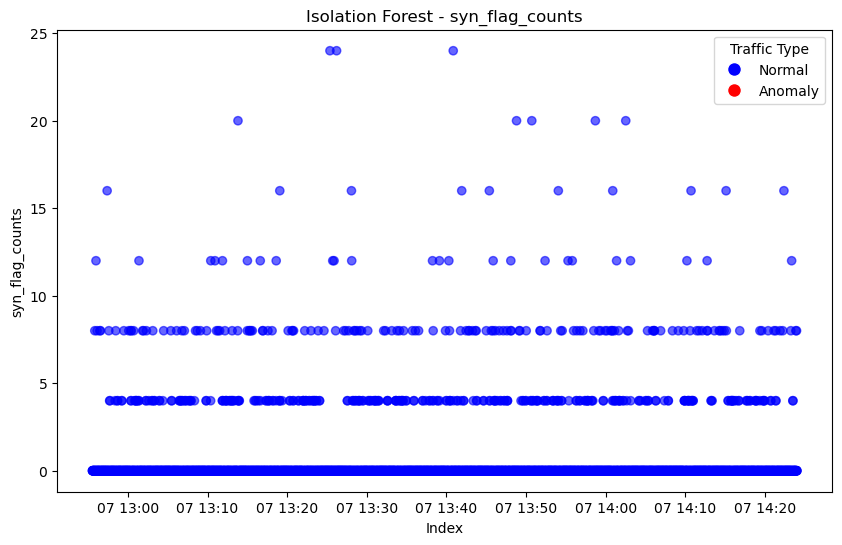

Index: (5310,)
Features: (5310,)


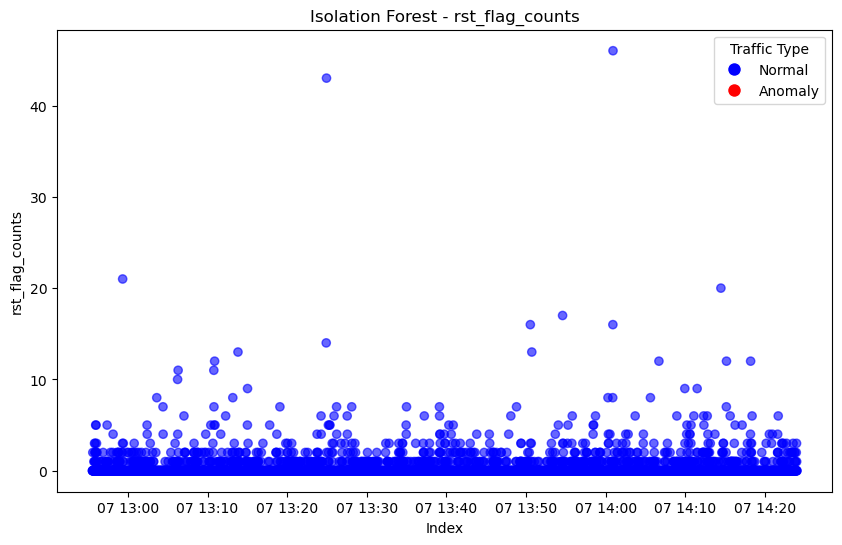

Index: (5310,)
Features: (5310,)


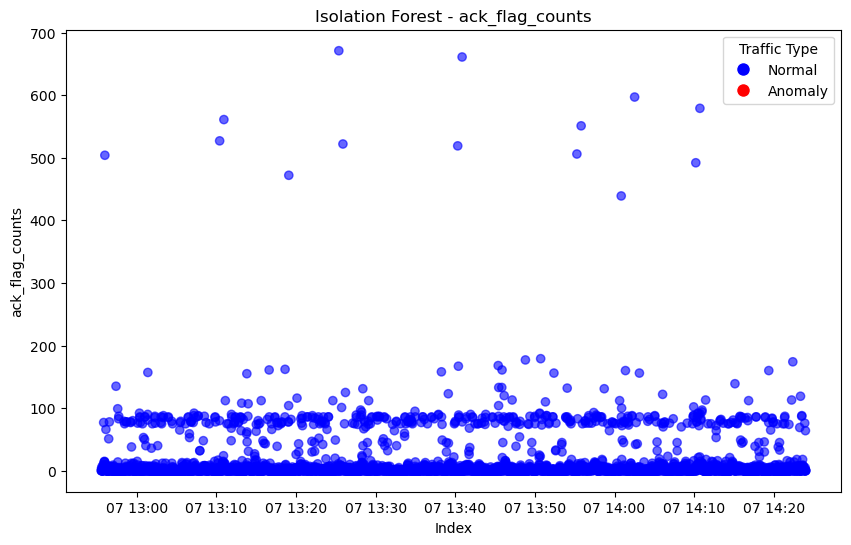

Index: (5310,)
Features: (5310,)


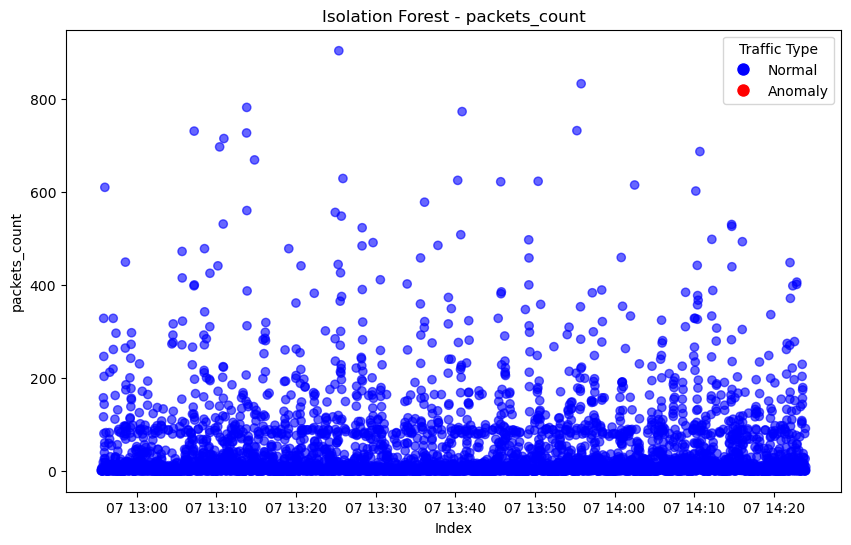

Index: (5310,)
Features: (5310,)


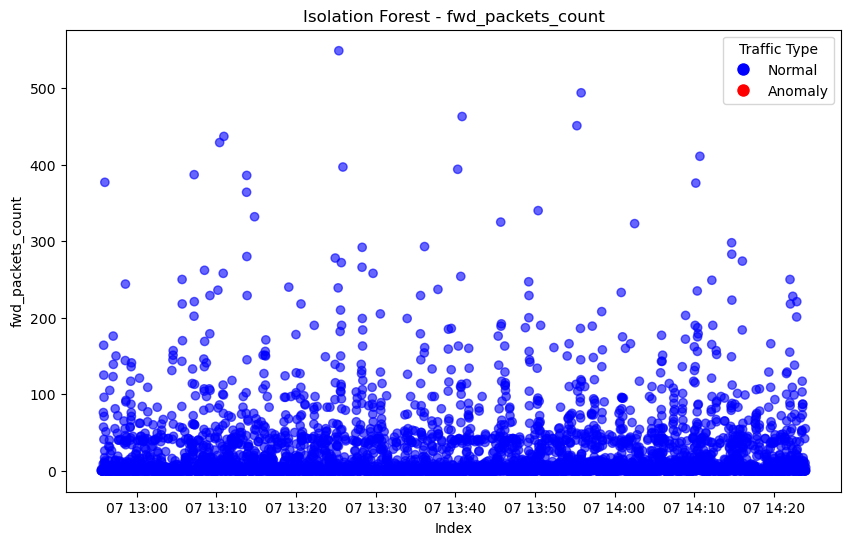

Index: (5310,)
Features: (5310,)


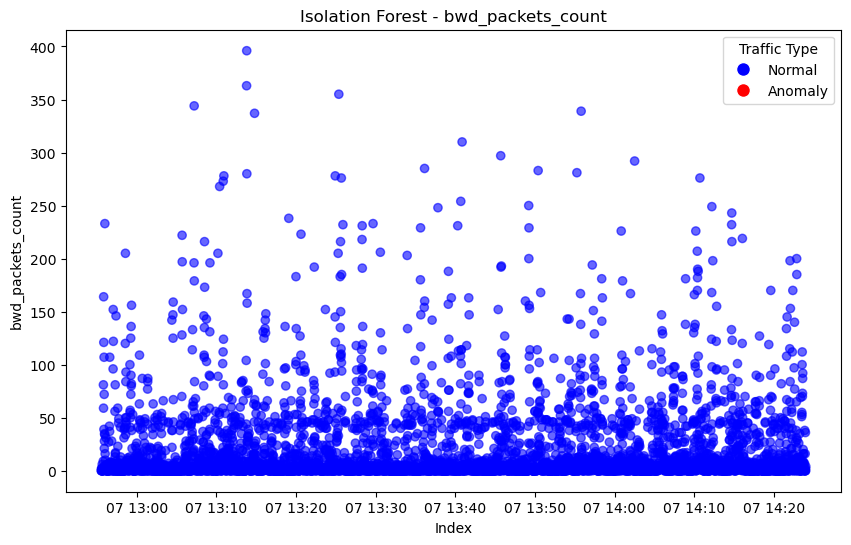

Index: (5310,)
Features: (5310,)


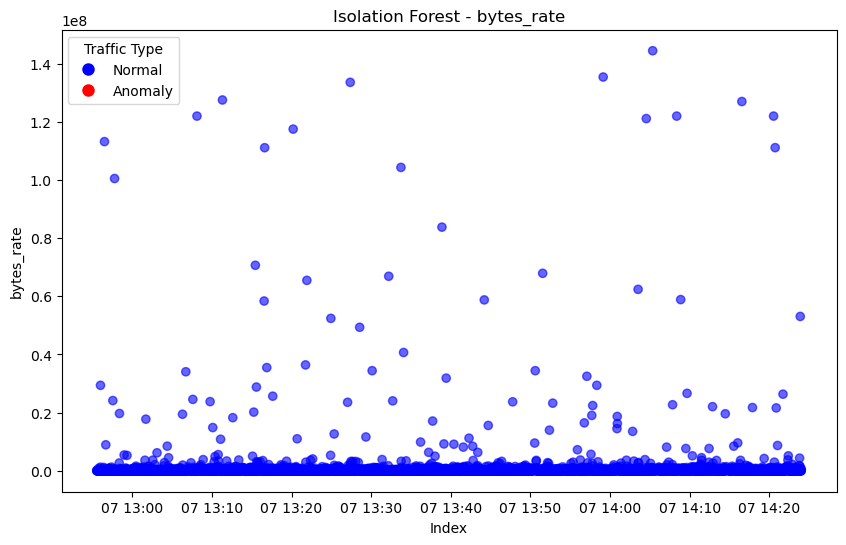

Index: (5310,)
Features: (5310,)


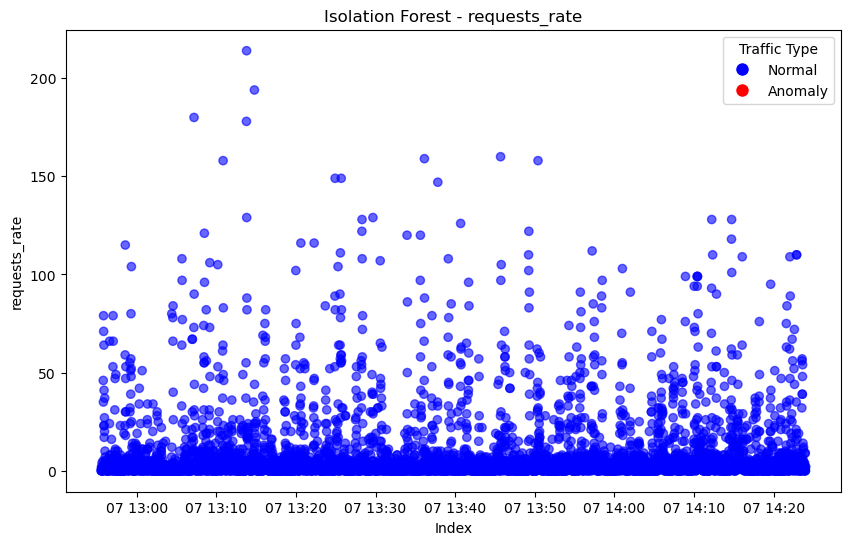

Index: (5310,)
Features: (5310,)


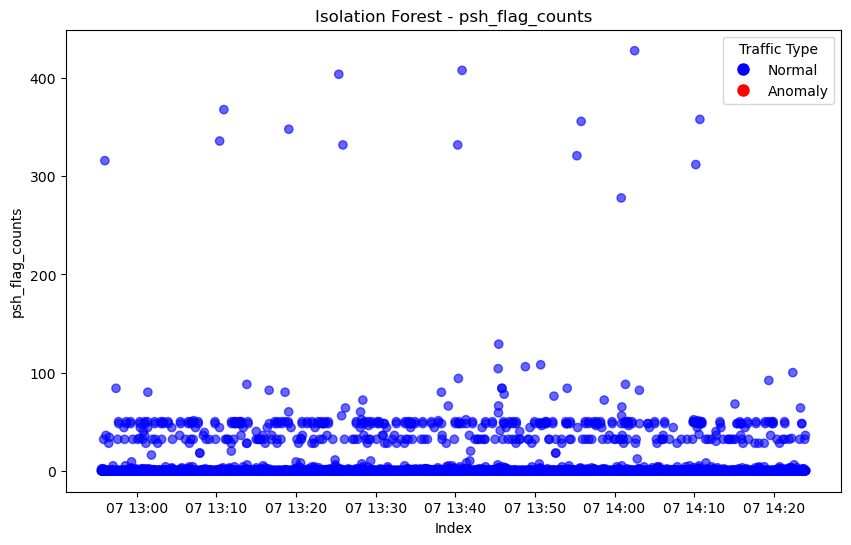

Index: (5310,)
Features: (5310,)


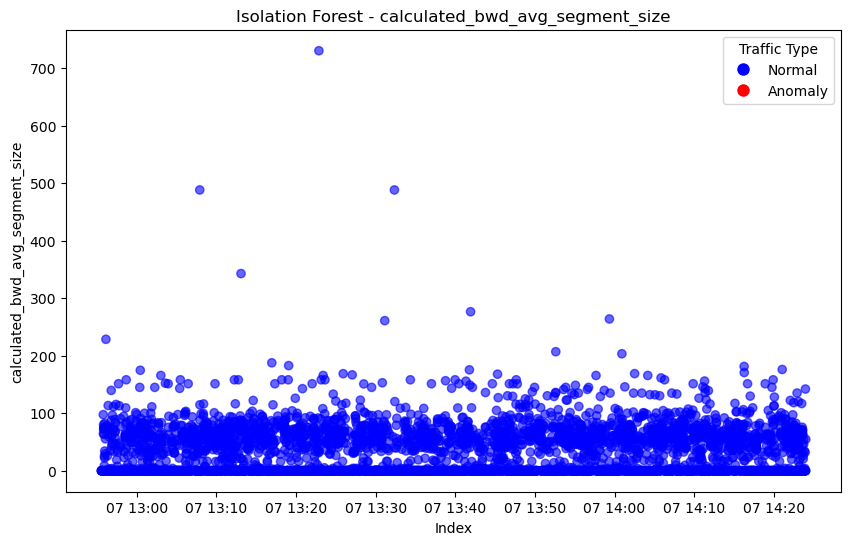

Index: (5310,)
Features: (5310,)


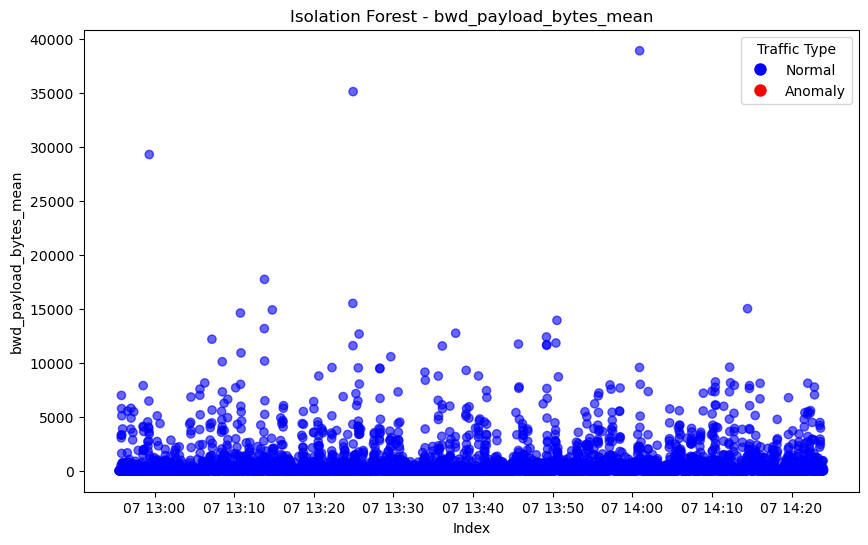

Index: (5310,)
Features: (5310,)


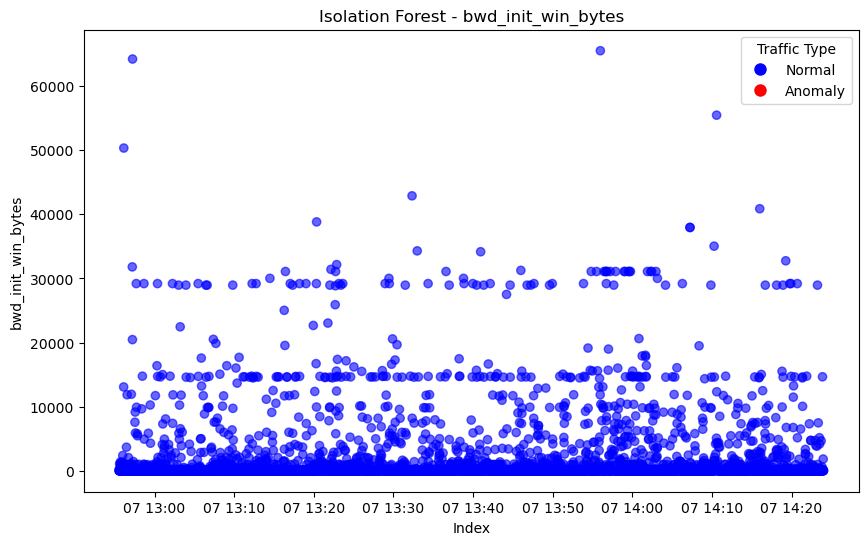

Index: (5310,)
Features: (5310,)


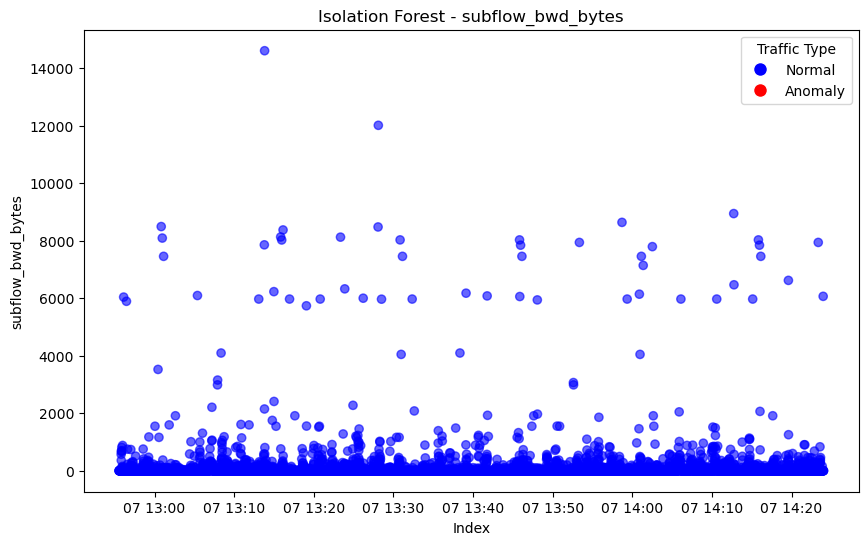

Index: (5310,)
Features: (5310,)


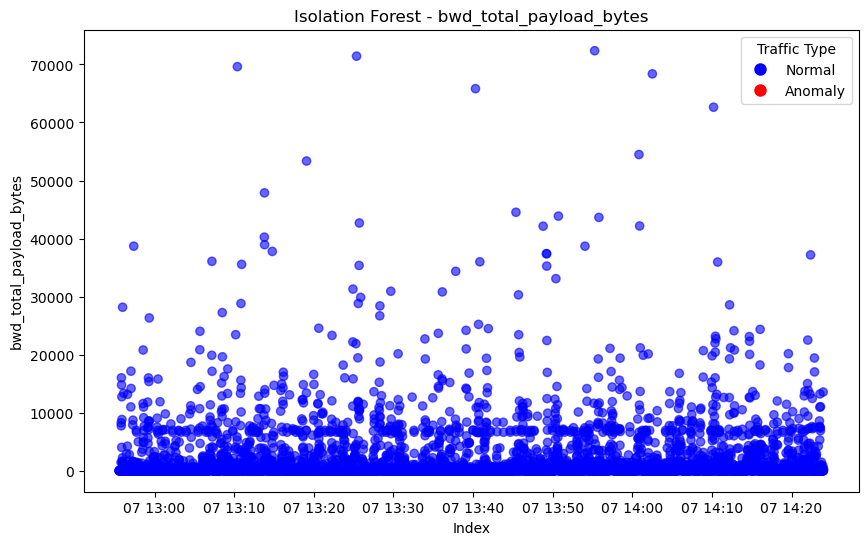

Index: (5310,)
Features: (5310,)


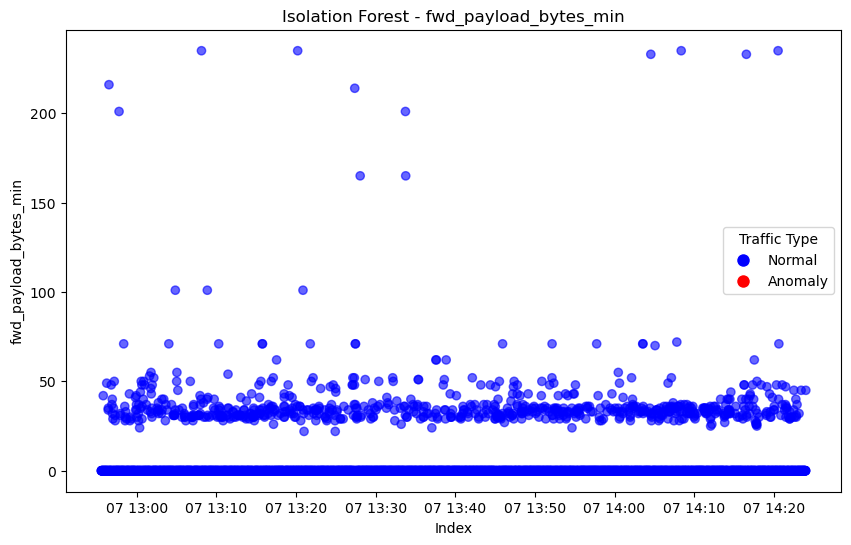

Index: (5310,)
Features: (5310,)


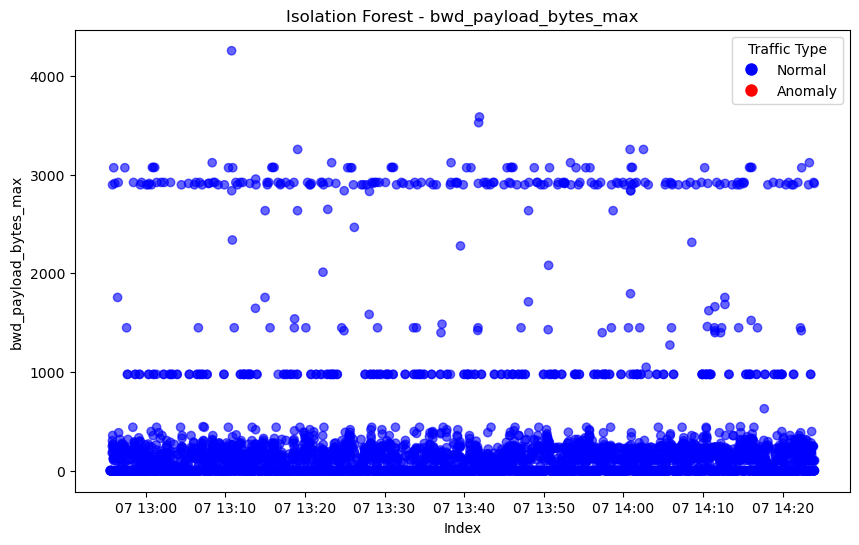

Index: (5310,)
Features: (5310,)


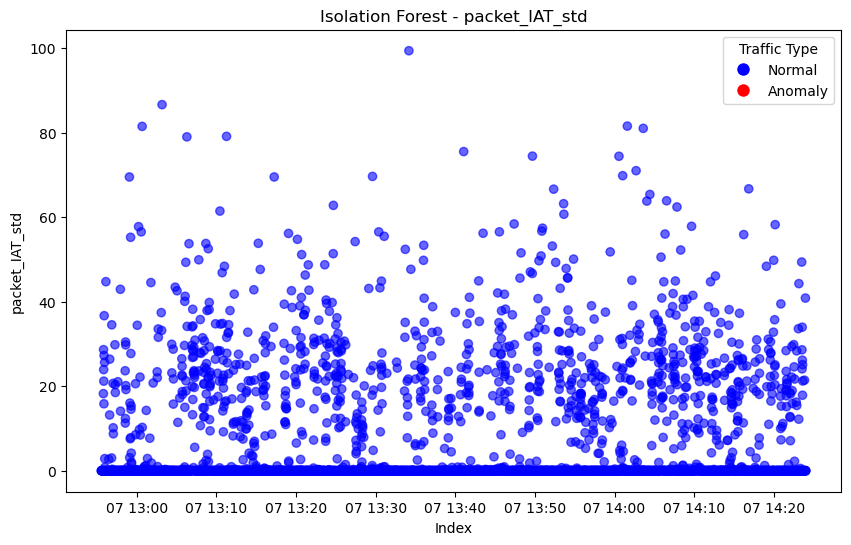

Index: (5310,)
Features: (5310,)


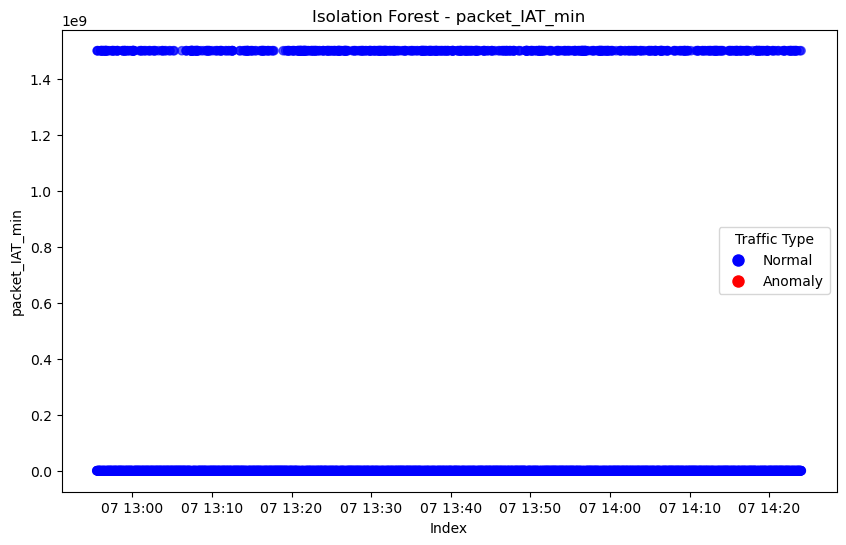

Index: (5310,)
Features: (5310,)


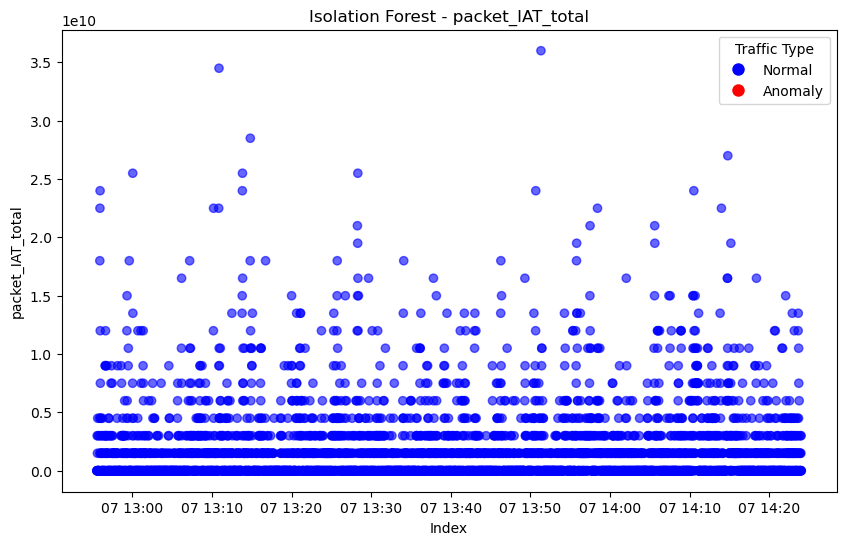

Index: (5310,)
Features: (5310,)


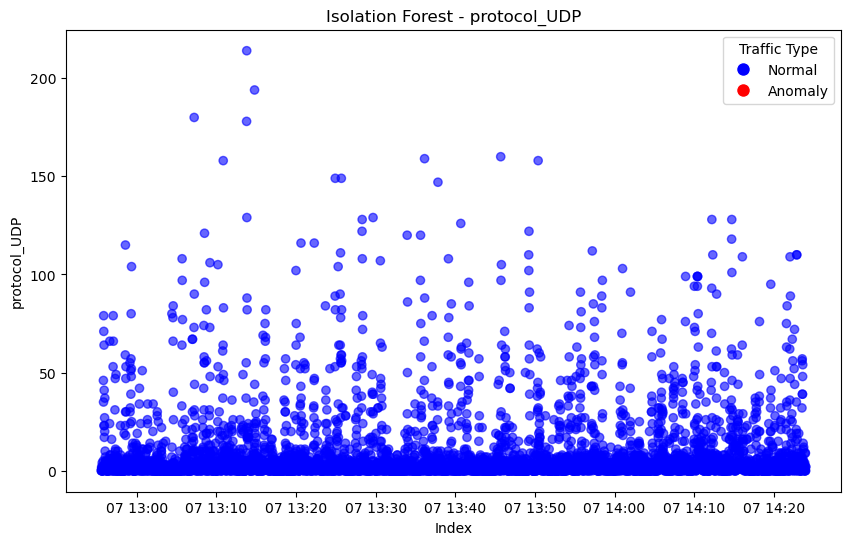

Index: (5310,)
Features: (5310,)


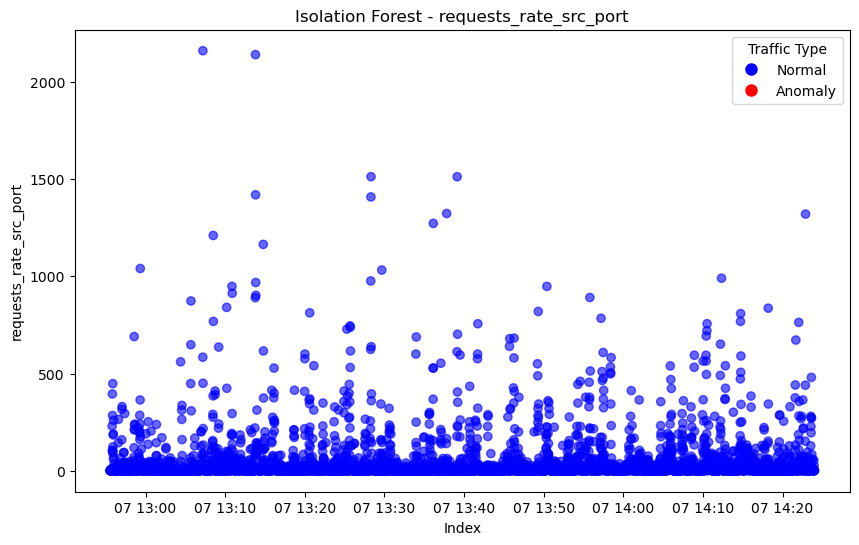

Index: (5310,)
Features: (5310,)


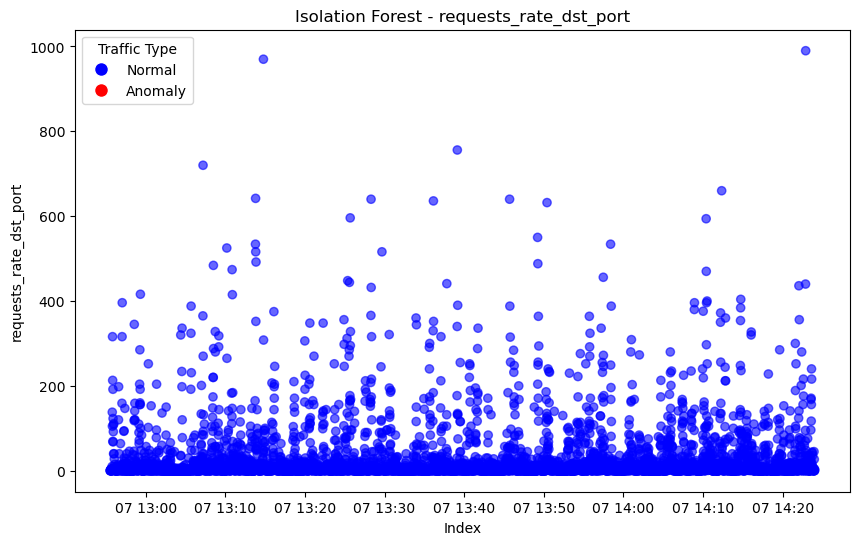

Index: (5310,)
Features: (5310,)


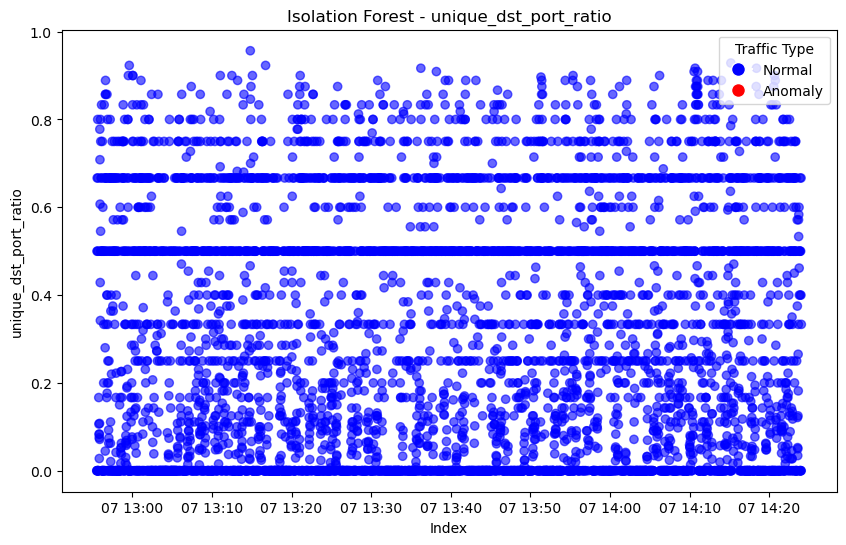

Index: (5310,)
Features: (5310,)


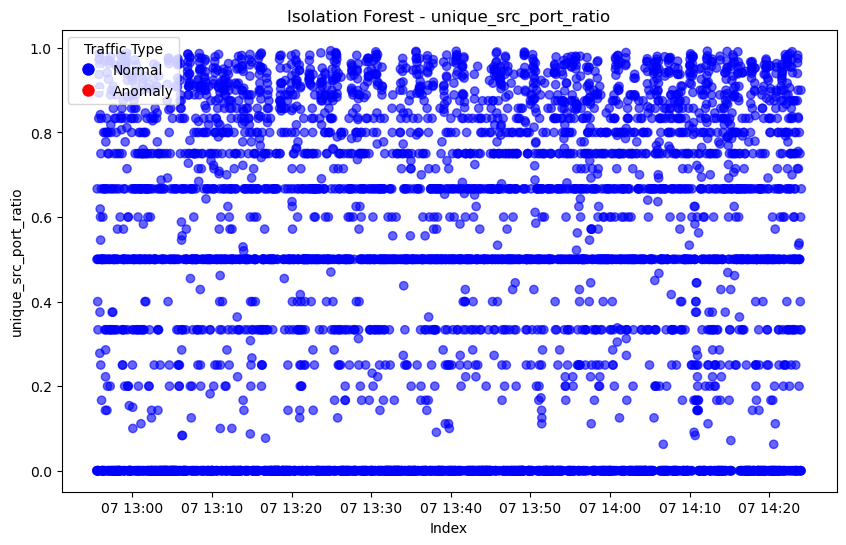

Index: (5310,)
Features: (5310,)


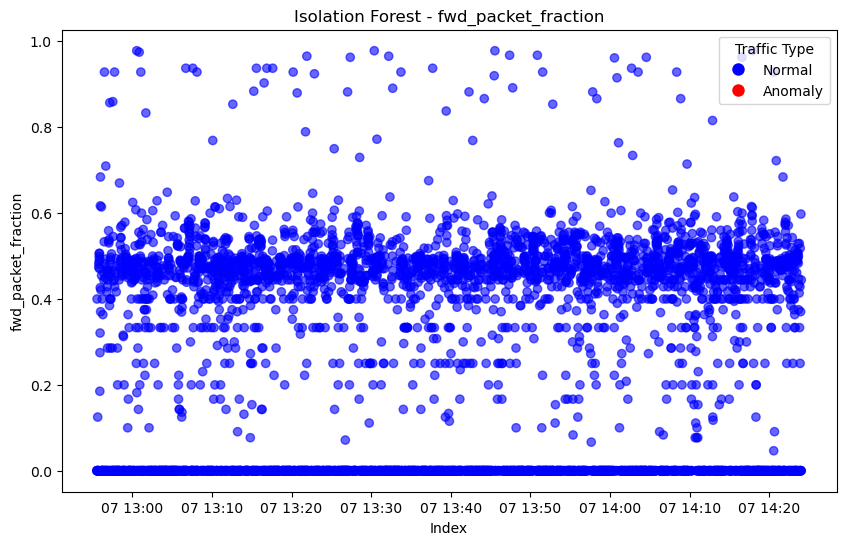

Index: (5310,)
Features: (5310,)


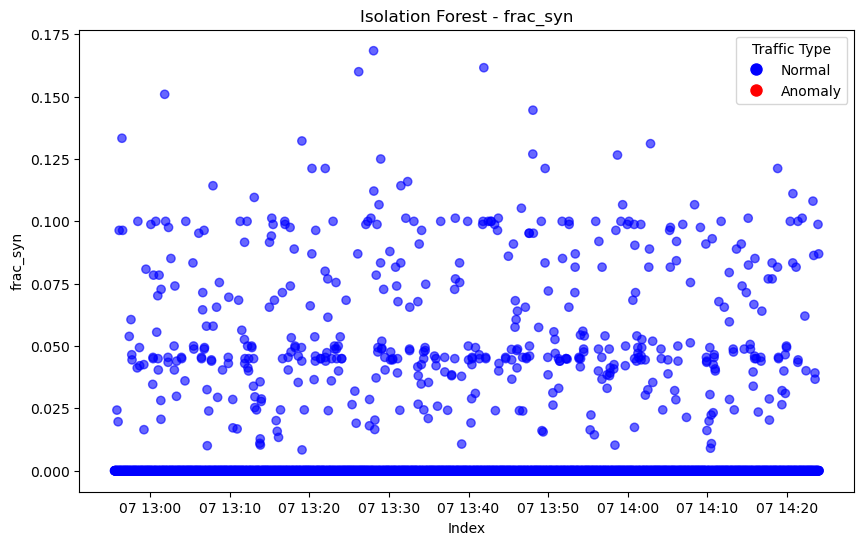

Index: (5310,)
Features: (5310,)


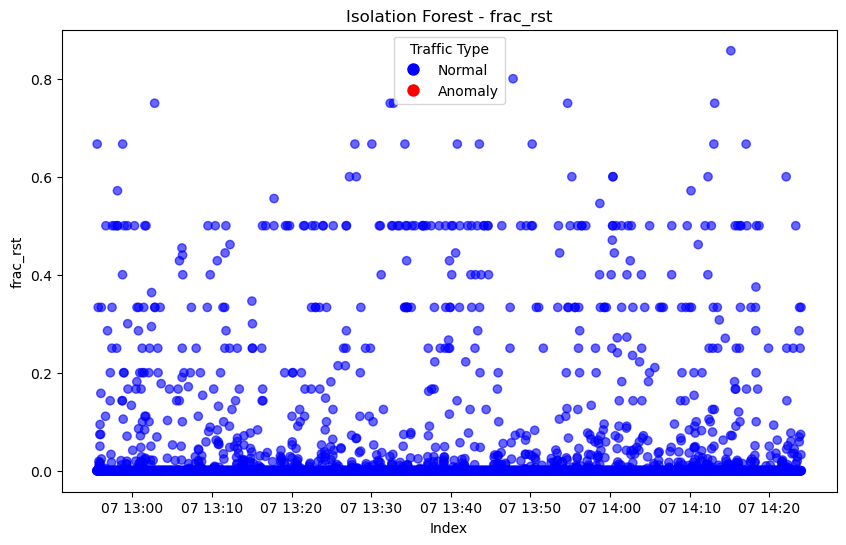

Index: (5310,)
Features: (5310,)


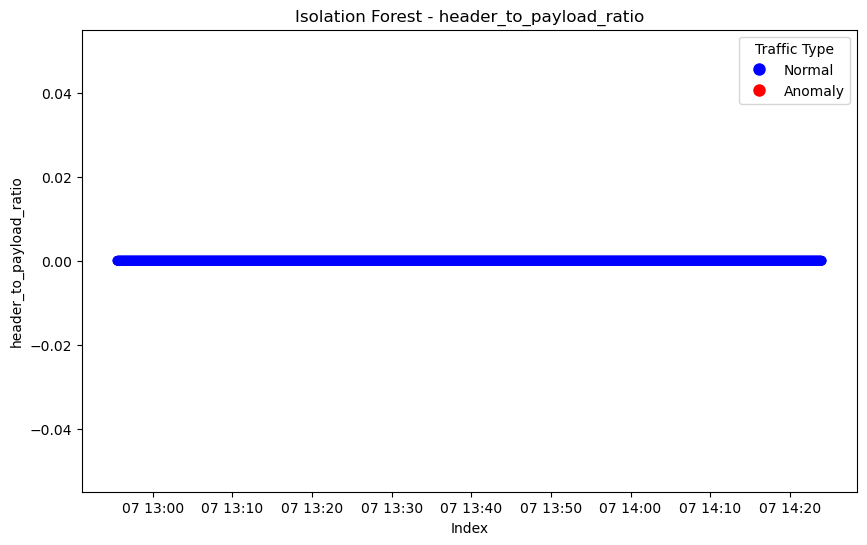

Index: (5310,)
Features: (5310,)


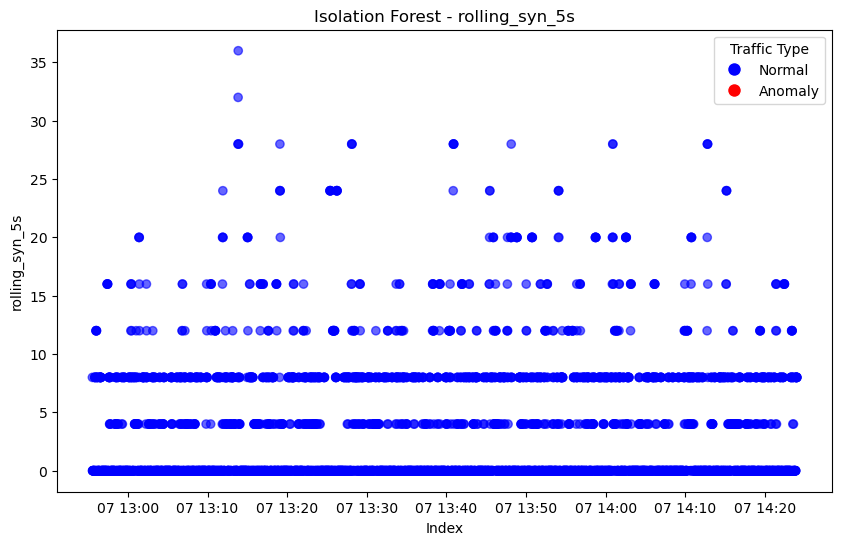

Index: (5310,)
Features: (5310,)


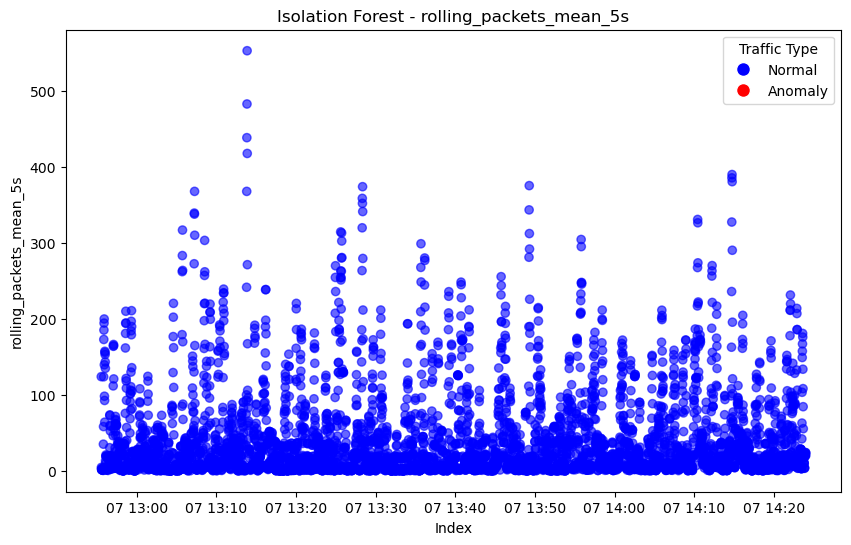

Index: (5310,)
Features: (5310,)


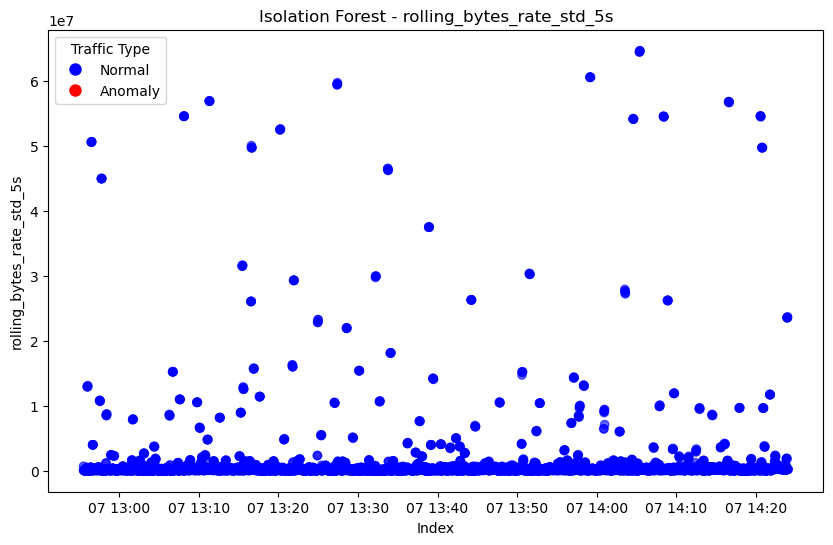

In [168]:
from sklearn.ensemble import IsolationForest

X = np.column_stack([approx_features, combined_data_agg.drop(columns=['label'])])
y = combined_data_agg['label']


c, f1 = find_best_contamination_for_isolation_forest(X, y)
model = IsolationForest(contamination=c, random_state=42)
anomaly_score = model.fit_predict(X)
score_model(anomaly_score, y)
visualize_isolation_forest_results(combined_data_agg[features], features, anomaly_score, start_time, end_time)

In [287]:
bening_subnet_agg, ddos_subnet_agg, combined_data_agg, features = load_and_prepare_sets("friday_benign.csv", "portscan.csv", aggregations)

In [301]:

X = combined_data_agg[features]
y = combined_data_agg['label']

c, f1 = find_best_contamination_for_isolation_forest(X, y)

model = IsolationForest(contamination=c, random_state=42)
anomaly_score = model.fit_predict(X)
#visualize_isolation_forest_results(X, features, anomaly_score)
score_model(anomaly_score, y)
print(f"F1: {f1}")


Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      2775
     Anomaly       0.71      0.33      0.45       123

    accuracy                           0.97      2898
   macro avg       0.84      0.66      0.72      2898
weighted avg       0.96      0.97      0.96      2898

F1: 0.9823686553873553


Ok, it's clear where's the DDOS attack. Aggregation and isolation forest combination should be good enough to track it down. However, it depends on the contamination parameter and might produce a lot of false positives.

Let's implement CUSUM

In [10]:
import torch
import numpy as np
from typing import Tuple


class CusumMeanDetector():
        
    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        
        self._reset()
        
        

    def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()
        
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint
        
        else:
            return 0, False
            
    
    def _reset(self) -> None:
        self.current_t = torch.zeros(1)
                
        self.current_obs = []
        
        self.current_mean = None
        self.current_std = None
            
    
    def _update_data(self, y: torch.tensor) -> None:
        self.current_t += 1
        self.current_obs.append(y.reshape(1))

        
    
    def _init_params(self) -> None:
        self.current_mean = torch.mean(torch.concat(self.current_obs))
        self.current_std = torch.std(torch.concat(self.current_obs))
             
    
    def _check_for_changepoint(self) -> Tuple[float,bool]:
        eps = 1e-8
        standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean) / (self.current_std + eps) * self.current_t**0.5
        prob = self._get_prob(standardized_sum).detach().numpy().item()
        
        return prob, prob < self._p_limit
    
    
    def _get_prob(self, y: torch.tensor) -> bool:
        p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
        prob = 2*(1 - p)
        
        return prob

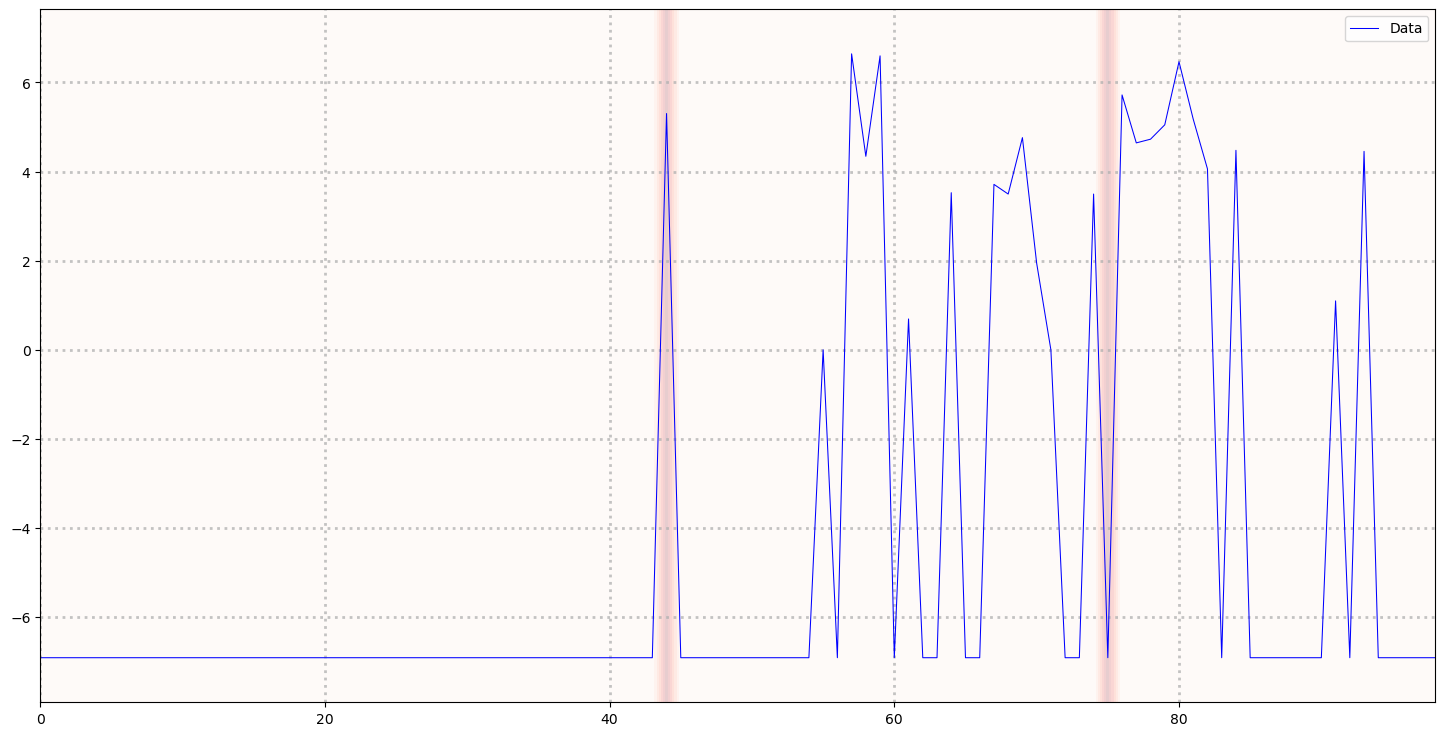

In [78]:
import matplotlib.pyplot as plt

np.random.seed(456)
torch.manual_seed(456)

test_log = np.log(combined_data_agg['ack_flag_counts'].values[1:100] + 0.001)

y = torch.tensor(test_log, dtype=torch.float32)

# Apply the detector
test = CusumMeanDetector()
outs = [test.predict_next(y[i]) for i in range(len(y))]

# Extract changepoints
cps = np.array([]); np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))


# Create mesh grid for visualization
X, Y = np.meshgrid(np.arange(len(y)), np.linspace(y.min()-1, y.max()+1))
Z = probs[X]

# Plot results
plt.figure(figsize=(18,9))
plt.contourf(X, Y, Z, alpha=0.2, cmap="Reds")
plt.plot(np.arange(len(y)), y.numpy(), lw=0.75, label="Data", color="blue")

# Detected changepoints
if len(cps) > 0:
    plt.axvline(cps[0], color="red", linestyle="dashed", label="Detected changepoints", lw=2)
    [plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted", lw=2)
plt.legend()
plt.show()

As we can see from above plot, entropy based CUSUM doesn't really work for network use case, because there's no stable distribution of data. Treshold based CUSUM requires a constant treshold value which isn't stable for network traffic.

Let's try to apply PCA on ddos_loit dataset and compare Isolation Forest results on principle components and direct features 

In [218]:
bening_subnet_agg, ddos_subnet_agg, combined_data_agg, features = load_and_prepare_sets("friday_benign.csv", "portscan.csv", aggregations)

In [455]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

PCA_components = 10

pca = PCA(n_components=PCA_components)

principal_components = pca.fit_transform(combined_data_agg)

X = principal_components
y = combined_data_agg['label']

c, f1 = find_best_contamination_for_isolation_forest(X, y)

model = IsolationForest(contamination=c, random_state=42)
anomaly_score = model.fit_predict(X)
score_model(anomaly_score, y)
print(f"F1 {f1}")

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

As we can see, peformance is way worse. I believe the problem arises because Isolation Forest is a robust to feature dimension alg and PCA simple removes important details, while keeping most of the regular traffic. I've tried to use no the first components, but the last ones or ones in the middle - no help.

Let's see what we can get with Wavelet Transform

In [30]:
import pywt

def shrink_signal(signal):
    """
    Pairwise "OR" on a signal of -1 and +1, returning -1 if both are -1,
    and +1 if at least one is +1.
    """

    signal = np.asarray(signal)
    if signal.shape[0] % 2 != 0:
        raise ValueError("Signal length must be even")

    # Reshape so each row is a pair [x1, x2].
    pairs = signal.reshape(-1, 2)

    # For -1/1, 'OR' is equivalent to taking the maximum in each pair.
    shrunk = np.minimum(pairs[:, 0], pairs[:, 1])

    return shrunk

coefs = None

for feature in combined_data_agg.drop(columns=['label']).columns:
    y = combined_data_agg['label']
    train = combined_data_agg.drop(columns=['label'])
    
    cA, cD = pywt.dwt(train[feature].values, 'db1')  # Ensure input is a NumPy array

    X = (cA + cD).reshape(-1, 1)  # Reshape for stacking

    if coefs is None:  # First feature, initialize
        coefs = X
    else:  # Stack horizontally
        coefs = np.column_stack([coefs, X])

print(coefs.shape)  # Check final shape

shrinked_y = shrink_signal(y)

c, f1 = find_best_contamination_for_isolation_forest(X, shrinked_y)

model = IsolationForest(contamination=c, random_state=42)

anomaly_score = model.fit_predict(X)
#visualize_isolation_forest_results(X, features, anomaly_score)
score_model(anomaly_score, shrinked_y)
print(f"F1: {f1}")

(14486, 33)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     13995
     Anomaly       0.00      0.00      0.00       491

    accuracy                           0.96     14486
   macro avg       0.48      0.49      0.49     14486
weighted avg       0.93      0.96      0.94     14486

F1: 0.9775550536420101


I want to try to train the model with  only benign data and then predict benign/malign sets

In [311]:
monday_bening_subnet_agg, _, _, _ = load_and_prepare_sets("monday_benign.csv", "ddos_loit.csv", aggregations, include_labels=True)
tuesday_bening_subnet_agg, _, _, _ = load_and_prepare_sets("tuesday_benign.csv", "ddos_loit.csv", aggregations, include_labels=True)
wednesday_bening_subnet_agg, _, _, _ = load_and_prepare_sets("wednesday_benign.csv", "ddos_loit.csv", aggregations, include_labels=True)
friday_bening_subnet_agg, _, friday_ddos_combined_agg, _ = load_and_prepare_sets("friday_benign.csv", "ddos_loit.csv", aggregations, include_labels=True)

2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.74      0.95      0.83      1083
     Anomaly       1.00      0.99      0.99     27889

    accuracy                           0.99     28972
   macro avg       0.87      0.97      0.91     28972
weighted avg       0.99      0.99      0.99     28972



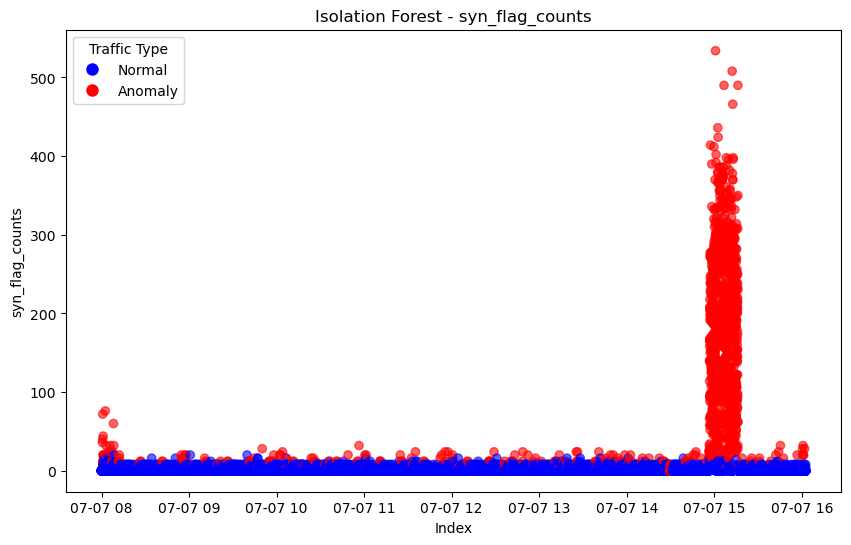

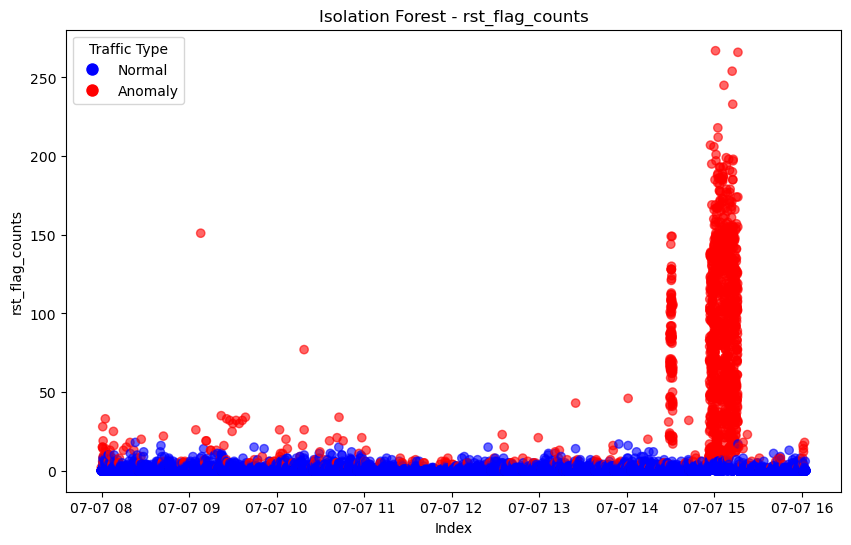

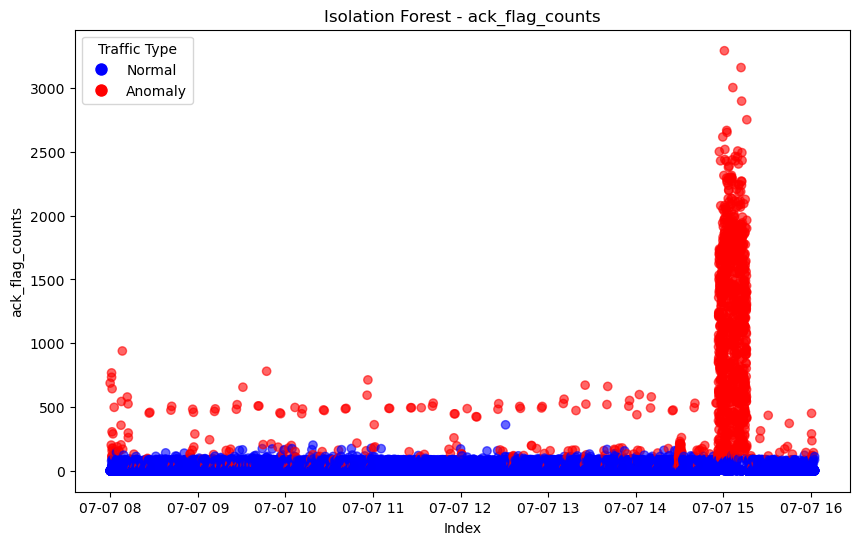

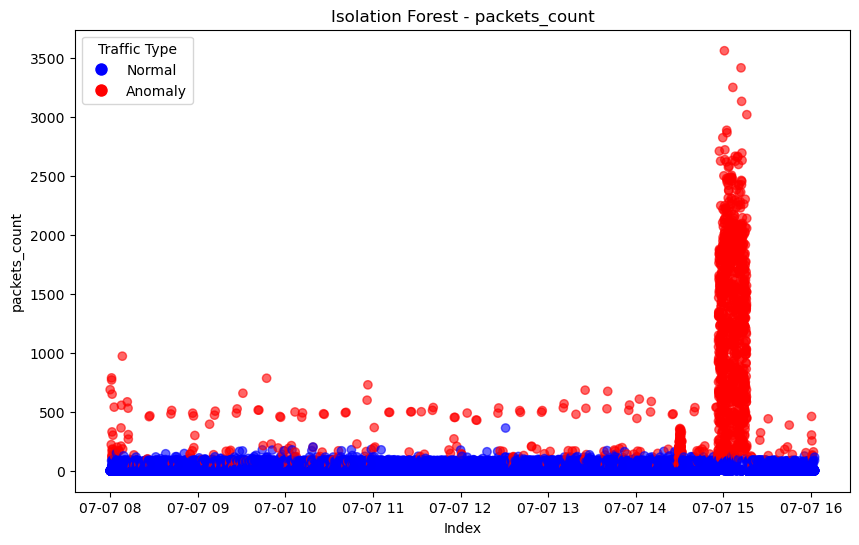

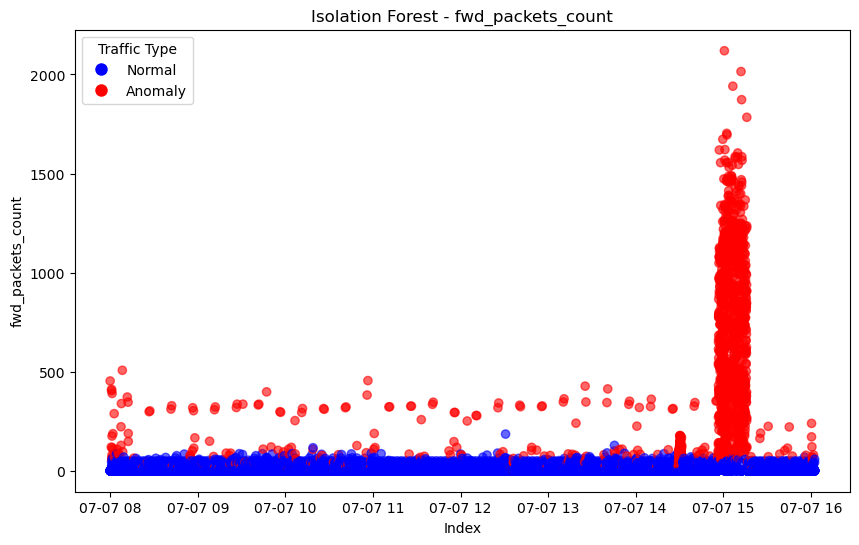

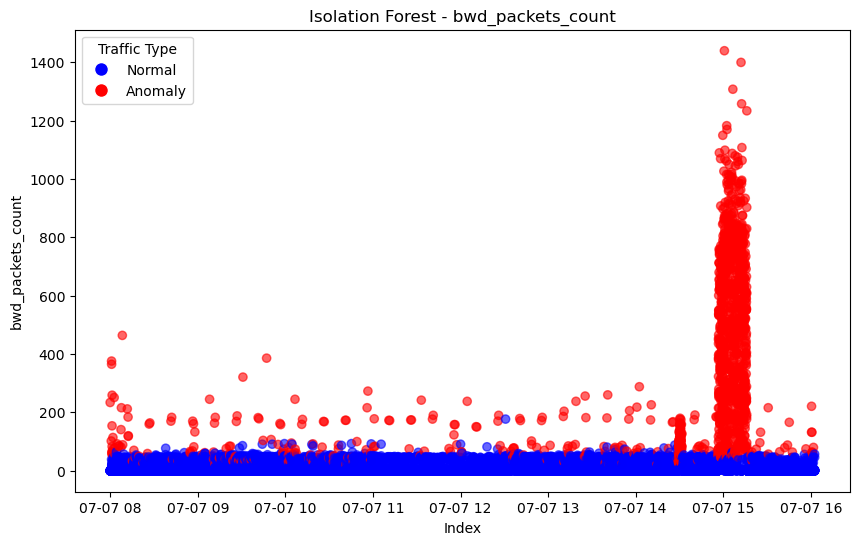

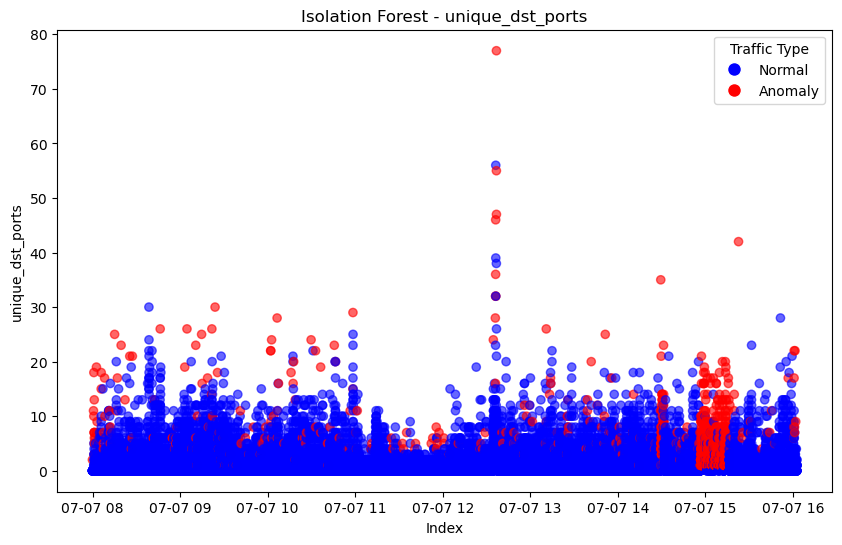

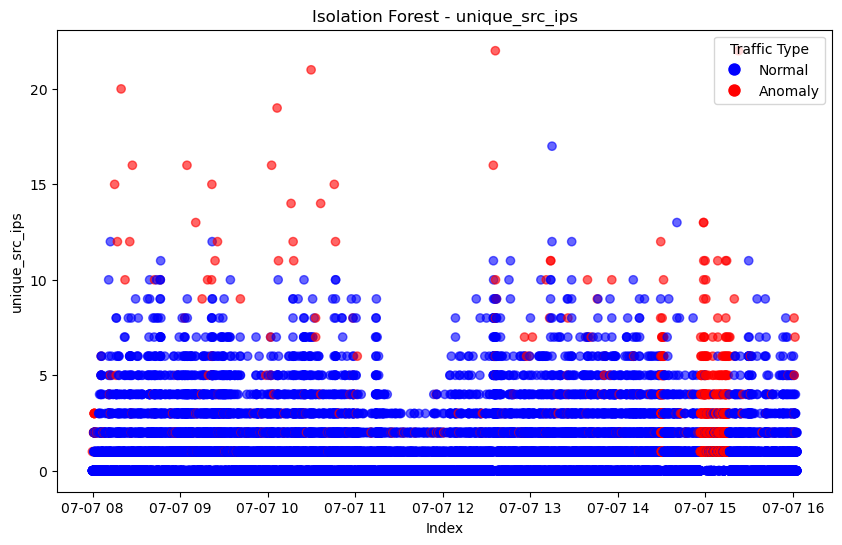

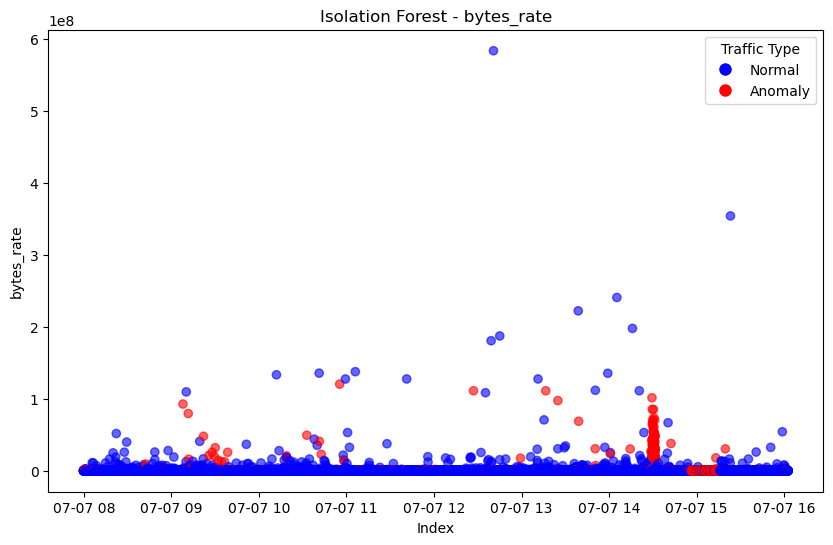

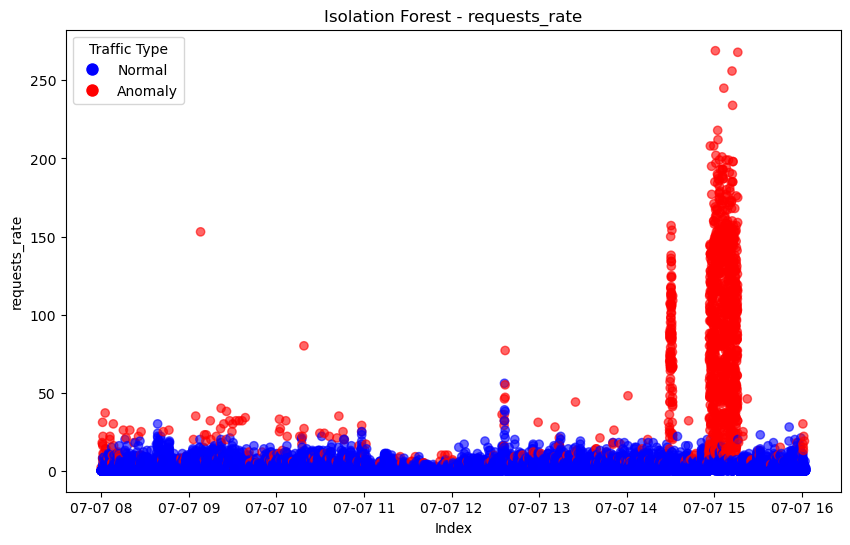

In [621]:
X = pd.concat([monday_bening_subnet_agg, tuesday_bening_subnet_agg, wednesday_bening_subnet_agg]).drop(columns=['label'])

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X)


y = friday_ddos_combined_agg['label']
print(y.nunique())
anomaly_score = model.predict(friday_ddos_combined_agg.drop(columns=['label']))
score_model(anomaly_score, y)
visualize_isolation_forest_results(friday_ddos_combined_agg.drop(columns=['label']), features, anomaly_score)

There are quite a few false positives...but overall it works, which is a good sign.